In [1]:
# Data Wrangling Library
import pandas as pd
import os
import plotly.graph_objects as go
import numpy as np

# Library for clustering
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

from keras.datasets import mnist
from scipy.optimize import linear_sum_assignment
from pyclustering.utils.metric import distance_metric, type_metric
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Library for Visualization
import matplotlib.pyplot as plt
import seaborn as sns  

# **Preprocessing IP**

In [2]:
# Directory for path file
directory = "/Users/efishery/Documents/Statistics Coach/DPMPTSP/Database/dbt_playground/data/"
file_path = [os.path.join(directory, filename) for filename in os.listdir(directory) 
             if filename.endswith('.xlsx') and 'spatialjoin' in filename]

file_path = [path for path in file_path if "(1).xlsx" in path]

In [3]:
# Adding empty list for inputting data from excel
dt = []

# Importing data investasi dan pengawasan
for i in range(0,len(file_path)) :
    dt_temp = pd.read_excel(file_path[i])
    dt.append(dt_temp)
 
dt_ip = pd.concat(dt, ignore_index = True)

In [4]:
dt_ip = dt_ip.drop(dt_ip.columns[[33,34]], axis = 1)

dt_ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089291 entries, 0 to 1089290
Data columns (total 33 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   Index                            1089291 non-null  int64  
 1   Service_Point                    1089291 non-null  object 
 2   Tahun                            1089291 non-null  int64  
 3   Id_Proyek                        1089291 non-null  object 
 4   Uraian_Jenis_Proyek              1089291 non-null  object 
 5   Nib                              1089291 non-null  int64  
 6   Nama_Perusahaan                  1089235 non-null  object 
 7   Tanggal_Terbit_Oss               1089291 non-null  object 
 8   Uraian_Status_Penanaman_Modal    1089291 non-null  object 
 9   Uraian_Jenis_Perusahaan          1089237 non-null  object 
 10  Uraian_Risiko_Proyek             1089291 non-null  object 
 11  nama_proyek                      1048832 non-null 

In [5]:
# Transform data into crosstab
filtered_dt_ip = dt_ip[dt_ip['Kota'].isin(['Jakarta Selatan','Jakarta Utara','Jakarta Barat','Jakarta Timur','Jakarta Pusat','Kepulauan Seribu'])]

# Definisikan kolom-kolom yang akan digunakan sebagai index, columns, dan values
# Setiap elemen dalam list adalah tuple dengan format: (index, columns, values, aggfunc)
crosstab_params = [
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Status_Penanaman_Modal', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Status_Penanaman_Modal', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Perusahaan', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Perusahaan', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Skala_Usaha', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Skala_Usaha', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Risiko_Proyek', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Risiko_Proyek', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Proyek', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'Uraian_Jenis_Proyek', 'Jumlah_Investasi', 'sum'),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'KL_Sektor_Pembina', None, None),
    (['Kota', 'Kecamatan', 'Kelurahan'], 'KL_Sektor_Pembina', 'Jumlah_Investasi', 'sum'),
]

# Dictionary untuk menyimpan hasil dari setiap crosstab
crosstab_results = {}

# Loop untuk membuat crosstab berdasarkan parameter yang didefinisikan
for i, (index, columns, values, aggfunc) in enumerate(crosstab_params, start=1):
    ct_name = f'ct_{i}'
    
    if values is None:
        crosstab_results[ct_name] = pd.crosstab(index=[filtered_dt_ip[col] for col in index],
                                                columns=filtered_dt_ip[columns])
    else:
        crosstab_results[ct_name] = pd.crosstab(index=[filtered_dt_ip[col] for col in index],
                                                columns=filtered_dt_ip[columns],
                                                values=filtered_dt_ip[values],
                                                aggfunc=aggfunc)
    
    crosstab_results[ct_name].reset_index(inplace=True)

# Menghitung jumlah investasi dengan groupby
total_investasi = filtered_dt_ip.groupby(['Kota', 'Kecamatan', 'Kelurahan'])['Jumlah_Investasi'].sum().reset_index()

In [6]:
# Menggabungkan seluruh tabel crosstab ke dalam satu tabel besar
combined_crosstab = crosstab_results['ct_1']

# Gabungkan crosstab lainnya
for ct_name in list(crosstab_results.keys())[1:]:
    combined_crosstab = combined_crosstab.merge(crosstab_results[ct_name], on=['Kota', 'Kecamatan', 'Kelurahan'], how='outer', suffixes=('', '_y'))

# Menghapus kolom yang tidak diperlukan setelah penggabungan
combined_crosstab = combined_crosstab.loc[:,~combined_crosstab.columns.duplicated()]

# Menggabungkan total_investasi ke dalam combined_crosstab
final_combined = combined_crosstab.merge(total_investasi, on=['Kota', 'Kecamatan', 'Kelurahan'], how='inner')

# **Preprocessing Izin**

In [7]:
# Directory for path file izin
path_izin = "/Users/efishery/Documents/Statistics Coach/DPMPTSP/Database/dbt_playground/data/data_izin.xlsx"

dt_izin = pd.read_excel(path_izin)

In [8]:
ct_izin = pd.crosstab(
    index = [dt_izin['level_wilayah'], dt_izin['recode_wilayah']]
    , columns = dt_izin['Bidang_Recode']
    , values = dt_izin['total_selesai']
    , aggfunc = 'sum'
)

ct_izin.reset_index(inplace = True)
ct_izin_kel = ct_izin[ct_izin['level_wilayah'].isin(['KEL'])]
ct_izin_kec = ct_izin[ct_izin['level_wilayah'].isin(['KEC'])]

In [9]:
# Kombinasikan antara ct_izin dan ct_investasi (final_combined)
ct_comb = final_combined.merge(ct_izin_kel, left_on=['Kelurahan'], right_on=['recode_wilayah'], how='inner')
ct_comb = ct_comb.drop(ct_comb.columns[[114,115]], axis = 1)

# Menyimpan hasil ke file Excel tanpa merge cell pada index
# ct_comb.to_excel('output_combined_crosstab.xlsx', index=False)

# Clustering KMeans

In [30]:
# Data preparation buat masuk ke kmeans
ct_comb_alt = ct_comb.drop(ct_comb.columns[[0,1,2]], axis = 1)
ct_comb_alt = ct_comb_alt.fillna(0)

columns_to_drop = [
    col_name for idx, col_name in enumerate(ct_comb_alt.columns)
    if idx < 110 and not col_name.endswith('_y')
]

ct_comb_alt = ct_comb_alt.drop(columns = columns_to_drop)

/var/folders/qj/vt4rcyh91s35vhsqftj_6fhh0000gn/T/ipykernel_2346/1945461720.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ct_comb_alt = ct_comb_alt.fillna(0)


In [31]:
# Kolom bereapa yang diapus kebanyakan jadinya di giniin aja
for idx, col_name in enumerate(ct_comb_alt.columns) : 
    print(f"Kolom {idx}: {col_name}")

Kolom 0: PMA_y
Kolom 1: PMDN_y
Kolom 2: Badan Hukum Lainnya_y
Kolom 3: Badan Layanan Umum (BLU)_y
Kolom 4: Koperasi_y
Kolom 5: Lembaga dan Bentuk Lainnya_y
Kolom 6: Organisasi Lainnya_y
Kolom 7: Perorangan_y
Kolom 8: Persekutuan Firma (Fa / Venootschap Onder Firma)_y
Kolom 9: Persekutuan Komanditer (CV / Commanditaire Vennootschap)_y
Kolom 10: Persekutuan Perdata_y
Kolom 11: Persekutuan dan Perkumpulan_y
Kolom 12: Perseroan Lainnya_y
Kolom 13: Perseroan Terbatas (PT)_y
Kolom 14: Perseroan Terbatas (PT) Perorangan_y
Kolom 15: Perusahaan Umum (Perum)_y
Kolom 16: Perusahaan Umum Daerah (Perumda)_y
Kolom 17: Yayasan_y
Kolom 18: Usaha Besar_y
Kolom 19: Usaha Kecil_y
Kolom 20: Usaha Menengah_y
Kolom 21: Usaha Mikro_y
Kolom 22: Menengah Rendah_y
Kolom 23: Menengah Tinggi_y
Kolom 24: Rendah_y
Kolom 25: Tinggi_y
Kolom 26: Kantor Cab Administrasi_y
Kolom 27: Pendukung_y
Kolom 28: Pendukung UMKU_y
Kolom 29: Perluasan_y
Kolom 30: Satu Lini Produksi_y
Kolom 31: Utama_y
Kolom 32: Badan Pengawas Tena

In [19]:
ct_comb_alt

,PMA_y,PMDN_y,Badan Hukum Lainnya_y,Badan Layanan Umum (BLU)_y,Koperasi_y,Lembaga dan Bentuk Lainnya_y,Organisasi Lainnya_y,Perorangan_y,Persekutuan Firma (Fa / Venootschap Onder Firma)_y,Persekutuan Komanditer (CV / Commanditaire Vennootschap)_y,...,Pariwisata,Pekerjaan Umum Dan Penataan Ruang,Pekerjaan Umum dan Penataan Ruang,Pelayanan Administrasi,Pendidikan,Perdagangan,Perhubungan,Pertanian,Sosial,Tenaga Kerja
0,0.000000e+00,2.367000e+09,0.0,0.0,0.0,0.0,0,5.670000e+08,0.0,0.000000e+00,...,0.0,15.0,0.0,847.0,0.0,0.0,0.0,0.0,7.0,39.0
1,7.500000e+08,8.318088e+08,0.0,0.0,0.0,0.0,0,7.518088e+08,0.0,3.000000e+08,...,0.0,27.0,0.0,744.0,15.0,0.0,0.0,0.0,7.0,36.0
2,3.000000e+06,2.906521e+09,0.0,0.0,12000000.0,0.0,0,1.159521e+09,0.0,1.618000e+09,...,0.0,37.0,0.0,544.0,3.0,0.0,0.0,0.0,7.0,17.0
3,4.342000e+10,7.103743e+09,0.0,0.0,6000000.0,0.0,0,3.141743e+09,0.0,1.050000e+09,...,0.0,17.0,0.0,1330.0,10.0,0.0,0.0,0.0,8.0,25.0
4,5.000000e+07,2.625000e+09,0.0,0.0,0.0,0.0,0,7.500000e+07,0.0,0.000000e+00,...,0.0,13.0,0.0,332.0,1.0,0.0,0.0,0.0,0.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.000000e+00,8.591857e+10,0.0,0.0,270000000.0,0.0,0,1.549900e+09,0.0,6.020000e+09,...,0.0,935.0,0.0,351.0,0.0,0.0,0.0,0.0,6.0,5.0
261,0.000000e+00,6.759624e+10,0.0,0.0,0.0,0.0,0,2.937245e+09,0.0,2.540000e+08,...,0.0,56.0,0.0,314.0,3.0,0.0,0.0,0.0,5.0,10.0
262,0.000000e+00,2.706486e+10,0.0,0.0,788111075.0,0.0,0,3.973022e+08,0.0,2.098000e+09,...,0.0,15.0,0.0,347.0,0.0,0.0,0.0,0.0,0.0,15.0
263,0.000000e+00,3.163726e+09,0.0,0.0,0.0,0.0,0,6.517257e+08,0.0,0.000000e+00,...,0.0,37.0,0.0,503.0,1.0,0.0,0.0,0.0,4.0,25.0


In [55]:
# pengecekan data yang ga jelas juga pake ini
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
ct_comb_alt.describe(include='all')

,Kota,Kecamatan,Kelurahan,PMA,PMDN,PMA_y,PMDN_y,Badan Hukum Lainnya,Badan Layanan Umum (BLU),Koperasi,Lembaga dan Bentuk Lainnya,Organisasi Lainnya,Perorangan,Persekutuan Firma (Fa / Venootschap Onder Firma),Persekutuan Komanditer (CV / Commanditaire Vennootschap),Persekutuan Perdata,Persekutuan dan Perkumpulan,Perseroan Lainnya,Perseroan Terbatas (PT),Perseroan Terbatas (PT) Perorangan,Perusahaan Umum (Perum),Perusahaan Umum Daerah (Perumda),Yayasan,Badan Hukum Lainnya_y,Badan Layanan Umum (BLU)_y,Koperasi_y,Lembaga dan Bentuk Lainnya_y,Organisasi Lainnya_y,Perorangan_y,Persekutuan Firma (Fa / Venootschap Onder Firma)_y,Persekutuan Komanditer (CV / Commanditaire Vennootschap)_y,Persekutuan Perdata_y,Persekutuan dan Perkumpulan_y,Perseroan Lainnya_y,Perseroan Terbatas (PT)_y,Perseroan Terbatas (PT) Perorangan_y,Perusahaan Umum (Perum)_y,Perusahaan Umum Daerah (Perumda)_y,Yayasan_y,Usaha Besar,Usaha Kecil,Usaha Menengah,Usaha Mikro,Usaha Besar_y,Usaha Kecil_y,Usaha Menengah_y,Usaha Mikro_y,Menengah Rendah,Menengah Tinggi,Rendah,Tinggi,Menengah Rendah_y,Menengah Tinggi_y,Rendah_y,Tinggi_y,Kantor Cab Administrasi,Pendukung,Pendukung UMKU,Perluasan,Satu Lini Produksi,Utama,Kantor Cab Administrasi_y,Pendukung_y,Pendukung UMKU_y,Perluasan_y,Satu Lini Produksi_y,Utama_y,Badan Pengawas Tenaga Nuklir,Bank Indonesia,Kementerian Agama,Kementerian Energi dan Sumber Daya Mineral,Kementerian Hukum dan Hak Asasi Manusia,Kementerian Investasi/Badan Koordinasi Penanaman Modal,Kementerian Kelautan dan Perikanan,Kementerian Kesehatan,Kementerian Ketenagakerjaan,Kementerian Keuangan,Kementerian Komunikasi dan Informatika,Kementerian Koperasi dan Usaha Kecil dan Menengah,Kementerian Lingkungan Hidup dan Kehutanan,Kementerian Pariwisata,Kementerian Pekerjaan Umum dan Perumahan Rakyat,"Kementerian Pendidikan, Kebudayaan, Riset, dan Teknologi",Kementerian Perdagangan,Kementerian Perhubungan,Kementerian Perindustrian,Kementerian Pertahanan,Kementerian Pertanian,Kepolisian Negara Republik Indonesia,Otoritas Jasa Keuangan,Badan Pengawas Tenaga Nuklir_y,Bank Indonesia_y,Kementerian Agama_y,Kementerian Energi dan Sumber Daya Mineral_y,Kementerian Hukum dan Hak Asasi Manusia_y,Kementerian Investasi/Badan Koordinasi Penanaman Modal_y,Kementerian Kelautan dan Perikanan_y,Kementerian Kesehatan_y,Kementerian Ketenagakerjaan_y,Kementerian Keuangan_y,Kementerian Komunikasi dan Informatika_y,Kementerian Koperasi dan Usaha Kecil dan Menengah_y,Kementerian Lingkungan Hidup dan Kehutanan_y,Kementerian Pariwisata_y,Kementerian Pekerjaan Umum dan Perumahan Rakyat_y,"Kementerian Pendidikan, Kebudayaan, Riset, dan Teknologi_y",Kementerian Perdagangan_y,Kementerian Perhubungan_y,Kementerian Perindustrian_y,Kementerian Pertahanan_y,Kementerian Pertanian_y,Kepolisian Negara Republik Indonesia_y,Otoritas Jasa Keuangan_y,Jumlah_Investasi,Esdm,Kehutanan,Kelautan Dan Perikanan,Kepemudaan dan Keolahragaan,Kesatuan Bangsa Dan Politik Dalam Negeri,Kesehatan,"Ketenteraman, ketertiban Umum dan Pelindungan Masyarakat",Lingkungan Hidup,Pariwisata,Pekerjaan Umum Dan Penataan Ruang,Pekerjaan Umum dan Penataan Ruang,Pelayanan Administrasi,Pendidikan,Perdagangan,Perhubungan,Pertanian,Sosial,Tenaga Kerja
count,265,265,265,265.000000,265.000000,2.650000e+02,2.650000e+02,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,265.000000,265.000000,265.000000,265.000000,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,265.000000,265.000000,265.000000,265.000000,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,265.000000,265.000000,265.000000,265.000000,265.000000,265.000000,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,2.650000e+02,265.000000,26

In [52]:
# PCA
# preprocessing data
numeric_columns = ct_comb_alt.select_dtypes(include = ['float64', 'int64']).columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(ct_comb_alt[numeric_columns])

pca = PCA(n_components = 20)
principal_components = pca.fit_transform(scaled_data)

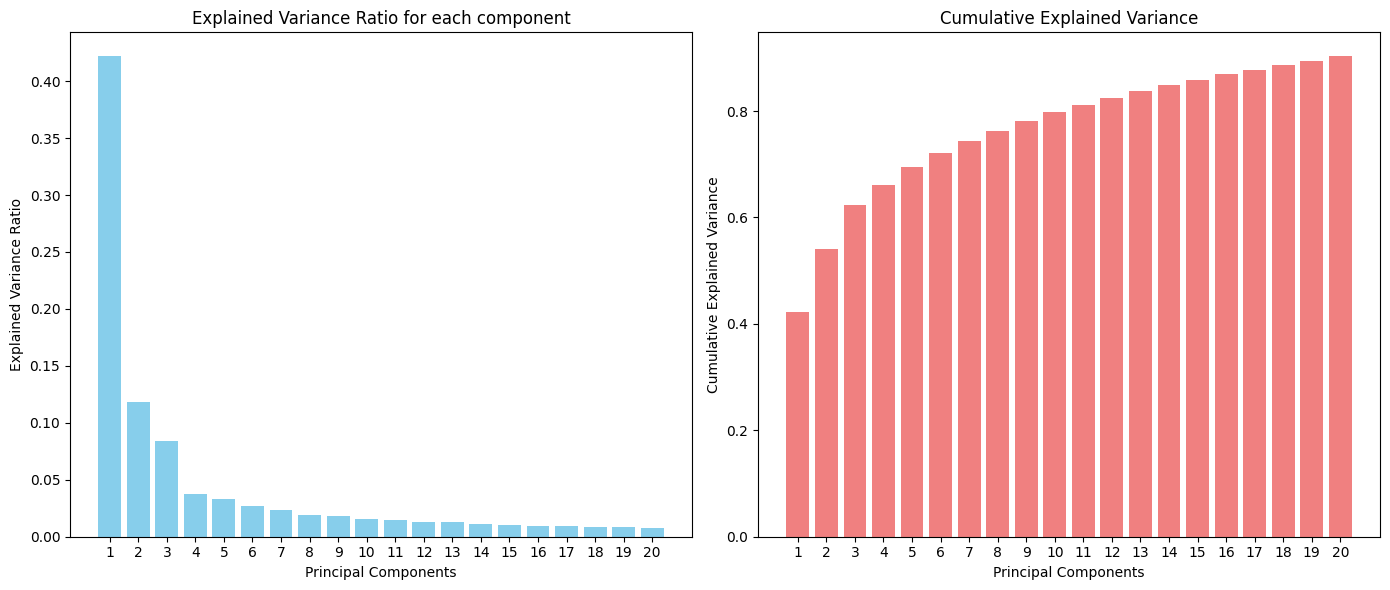

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = explained_variance.cumsum()

# Create a figure and axes for subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for explained variance ratio
ax[0].bar(range(1, len(explained_variance) + 1), explained_variance, color='skyblue')
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].set_title('Explained Variance Ratio for each component')
ax[0].set_xticks(range(1, len(explained_variance) + 1))

# Plot for cumulative explained variance
ax[1].bar(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='lightcoral')
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Cumulative Explained Variance')
ax[1].set_xticks(range(1, len(cumulative_explained_variance) + 1))

# Display the plots
plt.tight_layout()
plt.show()

In [24]:
#------------------------------------------------------------------------------------------------------------------------------------------
# Clustering Izin
#------------------------------------------------------------------------------------------------------------------------------------------

## Reduksi Variabel 
ct_izin_kel_test = ct_izin_kel.drop(columns = [
    'level_wilayah'
    ,'recode_wilayah'
    ,'Ketenteraman, ketertiban Umum dan Pelindungan Masyarakat'
    ,'Esdm'
    ,'Kehutanan'
    ,'Kelautan Dan Perikanan'
    ,'Kepemudaan dan Keolahragaan'
    ,'Kesatuan Bangsa Dan Politik Dalam Negeri'
    ,'Lingkungan Hidup'
    ,'Pariwisata'
    ,'Pekerjaan Umum dan Penataan Ruang'
    ,'Perdagangan'
    ,'Perhubungan'
    ,'Pendidikan'
    # ,'Pertanian'
    # ,'Sosial'
    # ,'Pelayanan Administrasi'
])

ct_izin_kel_test_2 = ct_izin_kel.drop(columns = [
    'level_wilayah'
    ,'recode_wilayah'
    ,'Ketenteraman, ketertiban Umum dan Pelindungan Masyarakat'
    ,'Esdm'
    ,'Kehutanan'
    ,'Kelautan Dan Perikanan'
    ,'Kepemudaan dan Keolahragaan'
    ,'Kesatuan Bangsa Dan Politik Dalam Negeri'
    ,'Lingkungan Hidup'
    ,'Pariwisata'
    ,'Pekerjaan Umum dan Penataan Ruang'
    ,'Perdagangan'
    ,'Perhubungan'
    ,'Pertanian'
    ,'Sosial'
    ,'Pendidikan'
    ,'Pelayanan Administrasi'
])

ct_izin_kel_test = ct_izin_kel_test.fillna(0)
ct_izin_kel_test_2 = ct_izin_kel_test_2.fillna(0)


In [25]:
#------------------------------------------------------------------------------------------------------------------------------------------
## Syntax percobaan Kmeans
#------------------------------------------------------------------------------------------------------------------------------------------

inertia = []
centroids = []
cluster_records = []
cluster_records_2 = []

K = range(1, 20)
for k in K : 
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(ct_izin_kel_test)
    inertia.append(kmeans.inertia_)
    centroids.append(kmeans.cluster_centers_)

    cluster_records.append({
        "Number of Clusters" : k
        , 'Inerta_1' : kmeans.inertia_
    })

for k in K : 
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(ct_izin_kel_test_2)
    inertia.append(kmeans.inertia_)
    centroids.append(kmeans.cluster_centers_)

    cluster_records_2.append({
        "Number of Clusters" : k
        , 'Inerta_2' : kmeans.inertia_
    })

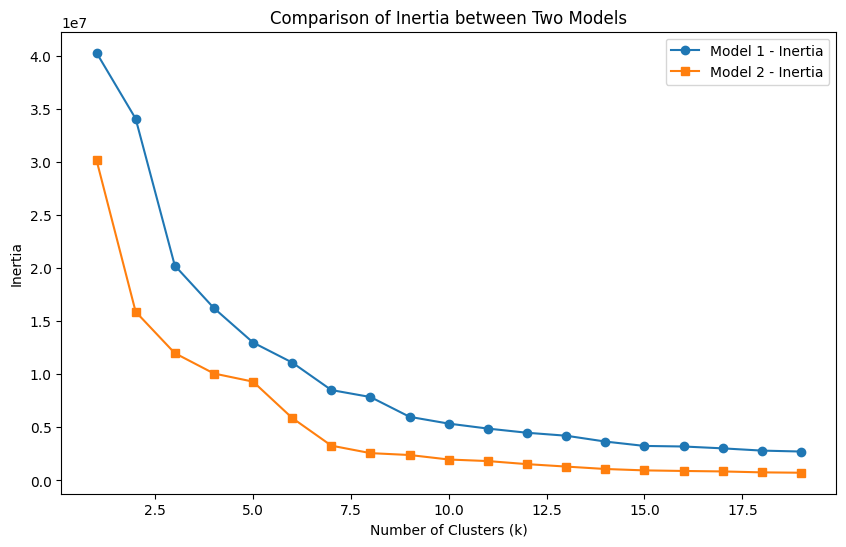

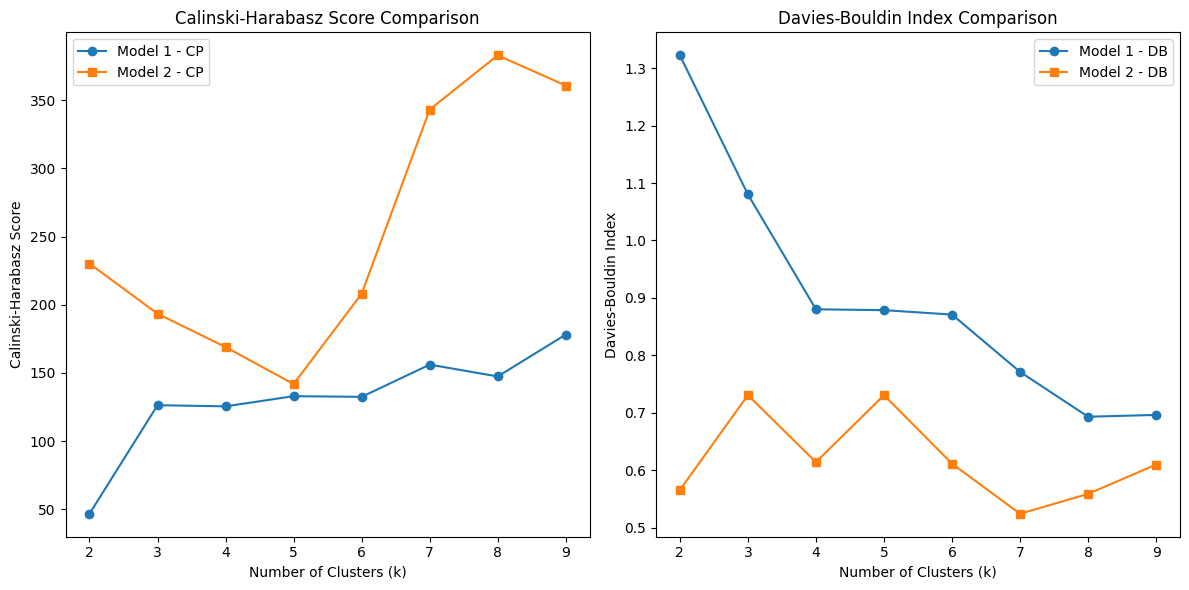

In [26]:
# Visualisasi Inertia
plt.figure(figsize=(10, 6))
plt.plot(K, [rec['Inerta_1'] for rec in cluster_records], label='Model 1 - Inertia', marker='o')
plt.plot(K, [rec['Inerta_2'] for rec in cluster_records_2], label='Model 2 - Inertia', marker='s')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Comparison of Inertia between Two Models')
plt.legend()
plt.show()

# Evaluasi dengan CP dan DB
cp_scores_model1 = []
db_scores_model1 = []
cp_scores_model2 = []
db_scores_model2 = []

for k in range(2,10):
    kmeans_model1 = KMeans(n_clusters=k, random_state=42).fit(ct_izin_kel_test)
    kmeans_model2 = KMeans(n_clusters=k, random_state=42).fit(ct_izin_kel_test_2)

    # CP dan DB untuk Model 1
    cp_scores_model1.append(calinski_harabasz_score(ct_izin_kel_test, kmeans_model1.labels_))
    db_scores_model1.append(davies_bouldin_score(ct_izin_kel_test, kmeans_model1.labels_))

    # CP dan DB untuk Model 2
    cp_scores_model2.append(calinski_harabasz_score(ct_izin_kel_test_2, kmeans_model2.labels_))
    db_scores_model2.append(davies_bouldin_score(ct_izin_kel_test_2, kmeans_model2.labels_))

# Visualisasi CP dan DB
plt.figure(figsize=(12, 6))

# CP Score
plt.subplot(1, 2, 1)
plt.plot(range(2,10), cp_scores_model1, label='Model 1 - CP', marker='o')
plt.plot(range(2,10), cp_scores_model2, label='Model 2 - CP', marker='s')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score Comparison')
plt.legend()

# DB Score
plt.subplot(1, 2, 2)
plt.plot(range(2,10), db_scores_model1, label='Model 1 - DB', marker='o')
plt.plot(range(2,10), db_scores_model2, label='Model 2 - DB', marker='s')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd

# Evaluasi dengan CP dan DB
cp_scores_model1 = []
db_scores_model1 = []
cp_scores_model2 = []
db_scores_model2 = []

for k in K:
    kmeans_model1 = KMeans(n_clusters=k, random_state=42).fit(ct_izin_kel_test)
    kmeans_model2 = KMeans(n_clusters=k, random_state=42).fit(ct_izin_kel_test_2)

    if k > 1:  # Hanya hitung CP dan DB jika jumlah klaster lebih dari 1
        # CP dan DB untuk Model 1
        cp_scores_model1.append(calinski_harabasz_score(ct_izin_kel_test, kmeans_model1.labels_))
        db_scores_model1.append(davies_bouldin_score(ct_izin_kel_test, kmeans_model1.labels_))

        # CP dan DB untuk Model 2
        cp_scores_model2.append(calinski_harabasz_score(ct_izin_kel_test_2, kmeans_model2.labels_))
        db_scores_model2.append(davies_bouldin_score(ct_izin_kel_test_2, kmeans_model2.labels_))
    else:
        # Tambahkan None untuk menjaga panjang daftar tetap sinkron
        cp_scores_model1.append(None)
        db_scores_model1.append(None)
        cp_scores_model2.append(None)
        db_scores_model2.append(None)

# Buat DataFrame untuk Tabel
evaluation_df = pd.DataFrame({
    "Number of Clusters (k)": K,
    "CP Model 1": cp_scores_model1,
    "DB Model 1": db_scores_model1,
    "CP Model 2": cp_scores_model2,
    "DB Model 2": db_scores_model2
})

# Menampilkan Tabel
pd.options.display.float_format = '{:,.2f}'.format  # Format angka dengan dua desimal
print(evaluation_df)

    Number of Clusters (k)  CP Model 1  DB Model 1  CP Model 2  DB Model 2
0                        1         NaN         NaN         NaN         NaN
1                        2       46.66        1.32      230.16        0.57
2                        3      126.29        1.08      193.41        0.73
3                        4      125.47        0.88      168.95        0.61
4                        5      132.92        0.88      141.83        0.73
5                        6      132.42        0.87      208.07        0.61
6                        7      156.05        0.77      343.08        0.52
7                        8      147.38        0.69      382.87        0.56
8                        9      178.10        0.70      360.61        0.61
9                       10      179.78        0.74      393.67        0.56
10                      11      178.93        0.76      383.25        0.55
11                      12      178.13        0.72      416.47        0.59
12                      1

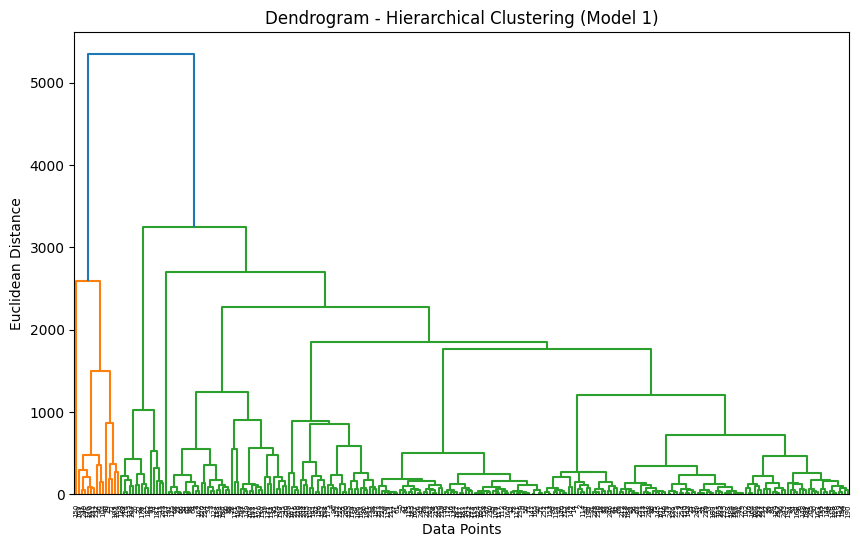

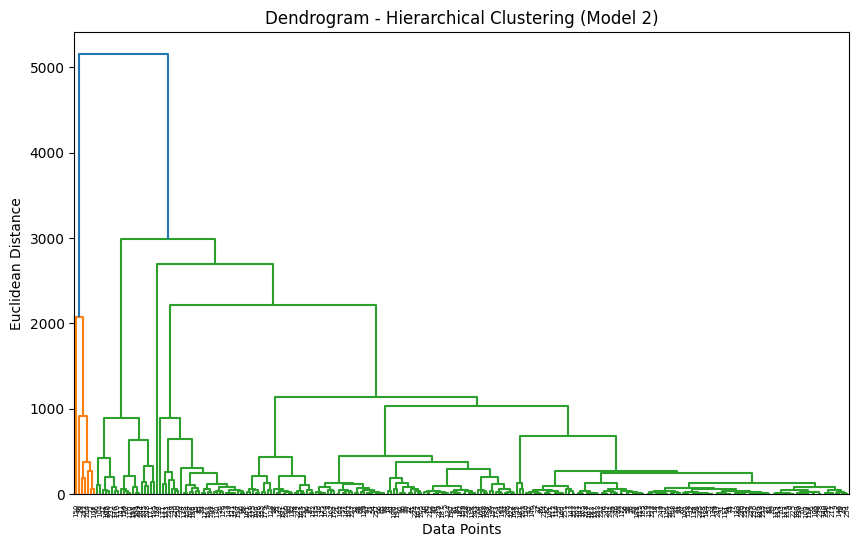

TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

In [27]:
# Hierarchical Clustering untuk ct_izin_kel_test
plt.figure(figsize=(10, 6))
dendrogram1 = sch.dendrogram(sch.linkage(ct_izin_kel_test, method='ward'))
plt.title('Dendrogram - Hierarchical Clustering (Model 1)')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

# Hierarchical Clustering untuk ct_izin_kel_test_2
plt.figure(figsize=(10, 6))
dendrogram2 = sch.dendrogram(sch.linkage(ct_izin_kel_test_2, method='ward'))
plt.title('Dendrogram - Hierarchical Clustering (Model 2)')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

# Fitting Hierarchical Clustering (Agglomerative Clustering)
n_clusters = 3  # Contoh: Pilih jumlah cluster berdasarkan dendrogram
hc_model1 = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_labels_model1 = hc_model1.fit_predict(ct_izin_kel_test)

hc_model2 = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_labels_model2 = hc_model2.fit_predict(ct_izin_kel_test_2)

# Menampilkan hasil clustering
print("Labels for Model 1:", hc_labels_model1)
print("Labels for Model 2:", hc_labels_model2)

In [29]:
# Tentukan jumlah cluster yang akan digunakan (4 clusters)
n_clusters = 4

# 1. KMeans untuk ct_izin_kel_test
kmeans_model1 = KMeans(n_clusters=n_clusters, random_state=42).fit(ct_izin_kel_test)
kmeans_labels_model1 = kmeans_model1.labels_

# 2. KMeans untuk ct_izin_kel_test_2
kmeans_model2 = KMeans(n_clusters=n_clusters, random_state=42).fit(ct_izin_kel_test_2)
kmeans_labels_model2 = kmeans_model2.labels_

# 3. Agglomerative Clustering untuk ct_izin_kel_test
hc_model1 = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_labels_model1 = hc_model1.fit_predict(ct_izin_kel_test)

# 4. Agglomerative Clustering untuk ct_izin_kel_test_2
hc_model2 = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hc_labels_model2 = hc_model2.fit_predict(ct_izin_kel_test_2)

# Menghitung CP dan DB untuk masing-masing metode
results = {
    "Model": ["KMeans Model 1", "KMeans Model 2", "AHC Model 1", "AHC Model 2"],
    "Calinski-Harabasz (CP)": [
        calinski_harabasz_score(ct_izin_kel_test, kmeans_labels_model1),
        calinski_harabasz_score(ct_izin_kel_test_2, kmeans_labels_model2),
        calinski_harabasz_score(ct_izin_kel_test, hc_labels_model1),
        calinski_harabasz_score(ct_izin_kel_test_2, hc_labels_model2),
    ],
    "Davies-Bouldin (DB)": [
        davies_bouldin_score(ct_izin_kel_test, kmeans_labels_model1),
        davies_bouldin_score(ct_izin_kel_test_2, kmeans_labels_model2),
        davies_bouldin_score(ct_izin_kel_test, hc_labels_model1),
        davies_bouldin_score(ct_izin_kel_test_2, hc_labels_model2),
    ],
}

# Menampilkan hasil dalam bentuk DataFrame
results_df = pd.DataFrame(results)
pd.options.display.float_format = '{:,.2f}'.format  # Format angka
print(results_df)

            Model  Calinski-Harabasz (CP)  Davies-Bouldin (DB)
0  KMeans Model 1                  125.47                 0.88
1  KMeans Model 2                  168.96                 0.61
2     AHC Model 1                  115.38                 0.55
3     AHC Model 2                  205.64                 0.58


In [48]:
# Konversi hc_labels_model1 menjadi DataFrame atau Series
hc_labels_df = pd.DataFrame(kmeans_labels_model2, columns=['Cluster Label'])

# Gabungkan dengan ct_izin_kel_test
ct_izin_kel_test_with_labels = ct_izin_kel_test_2.copy()  # Salin data asli
ct_izin_kel_test_with_labels['Cluster Label'] = hc_labels_df

In [50]:
# Hitung jumlah anggota tiap cluster
cluster_sizes = ct_izin_kel_test_with_labels.groupby('Cluster Label').size()
print("Cluster Sizes:")
print(cluster_sizes)

# Hitung rata-rata tiap cluster untuk kolom numerik
grouped_mean = ct_izin_kel_test_with_labels[
    'Kesehatan'
    , 'Pekerjaan Umum dan Penataan Ruang'
    , 'Tenaga Kerja'
].groupby('Cluster Label').mean()

# 5. Buat heatmap dari rata-rata cluster
plt.figure(figsize=(20, 10))
sns.heatmap(grouped_mean, annot=True, fmt=".0f", cmap='coolwarm')
plt.title("Heatmap of Cluster Averages for Numeric Columns")
plt.show()

Cluster Sizes:
Cluster Label
0.00     26
1.00      7
2.00    182
3.00      1
dtype: int64


KeyError: ('Kesehatan', 'Pekerjaan Umum dan Penataan Ruang', 'Tenaga Kerja')

In [43]:
ct_izin_kel_test_with_labels.groupby('Cluster Label').size()

Cluster Label
0.00     13
1.00    191
2.00     11
3.00      1
dtype: int64

# **Clustering Investasi**

In [44]:
ct_inv_kel = pd.read_excel("ct_investasi_edited24121.xlsx", sheet_name = "Kelurahan")
ct_inv_kec = pd.read_excel("ct_investasi_edited24121.xlsx", sheet_name = "Kecamatan")
ct_inv_kot = pd.read_excel("ct_investasi_edited24121.xlsx", sheet_name = "Kota")

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 [Text(1, 0, 'PMA'),
  Text(2, 0, 'PMDN'),
  Text(3, 0, 'Badan Hukum Lainnya'),
  Text(4, 0, 'Badan Layanan Umum (BLU)'),
  Text(5, 0, 'Koperasi'),
  Text(6, 0, 'Lembaga dan Bentuk Lainnya'),
  Text(7, 0, 'Organisasi Lainnya'),
  Text(8, 0, 'Perorangan'),
  Text(9, 0, 'Persekutuan Firma (Fa / Venootschap Onder Firma)'),
  Text(10, 0, 'Persekutuan Komanditer (CV / Commanditaire Vennootschap)'),
  Text(11, 0, 'Persekutuan Perdata'),
  Text(12, 0, 'Persekutuan dan Perkumpulan'),
  Text(13, 0, 'Perseroan Lainnya'),
  Text(14, 0, 'Perseroan Terbatas (PT)'),
  Text(15, 0, 'Perseroan Terbatas (PT) Perorangan'),
  Text(16, 0, 'Perusahaan Umum (Perum)'),
  Text(17, 0, 'Perusahaan Umum Daerah (Perumda)'),
  Text(18, 0, 'Yayasan'),
  Text(19, 0, 'Usaha Besar'),
  Text(20, 0, 'Usaha Kecil'),

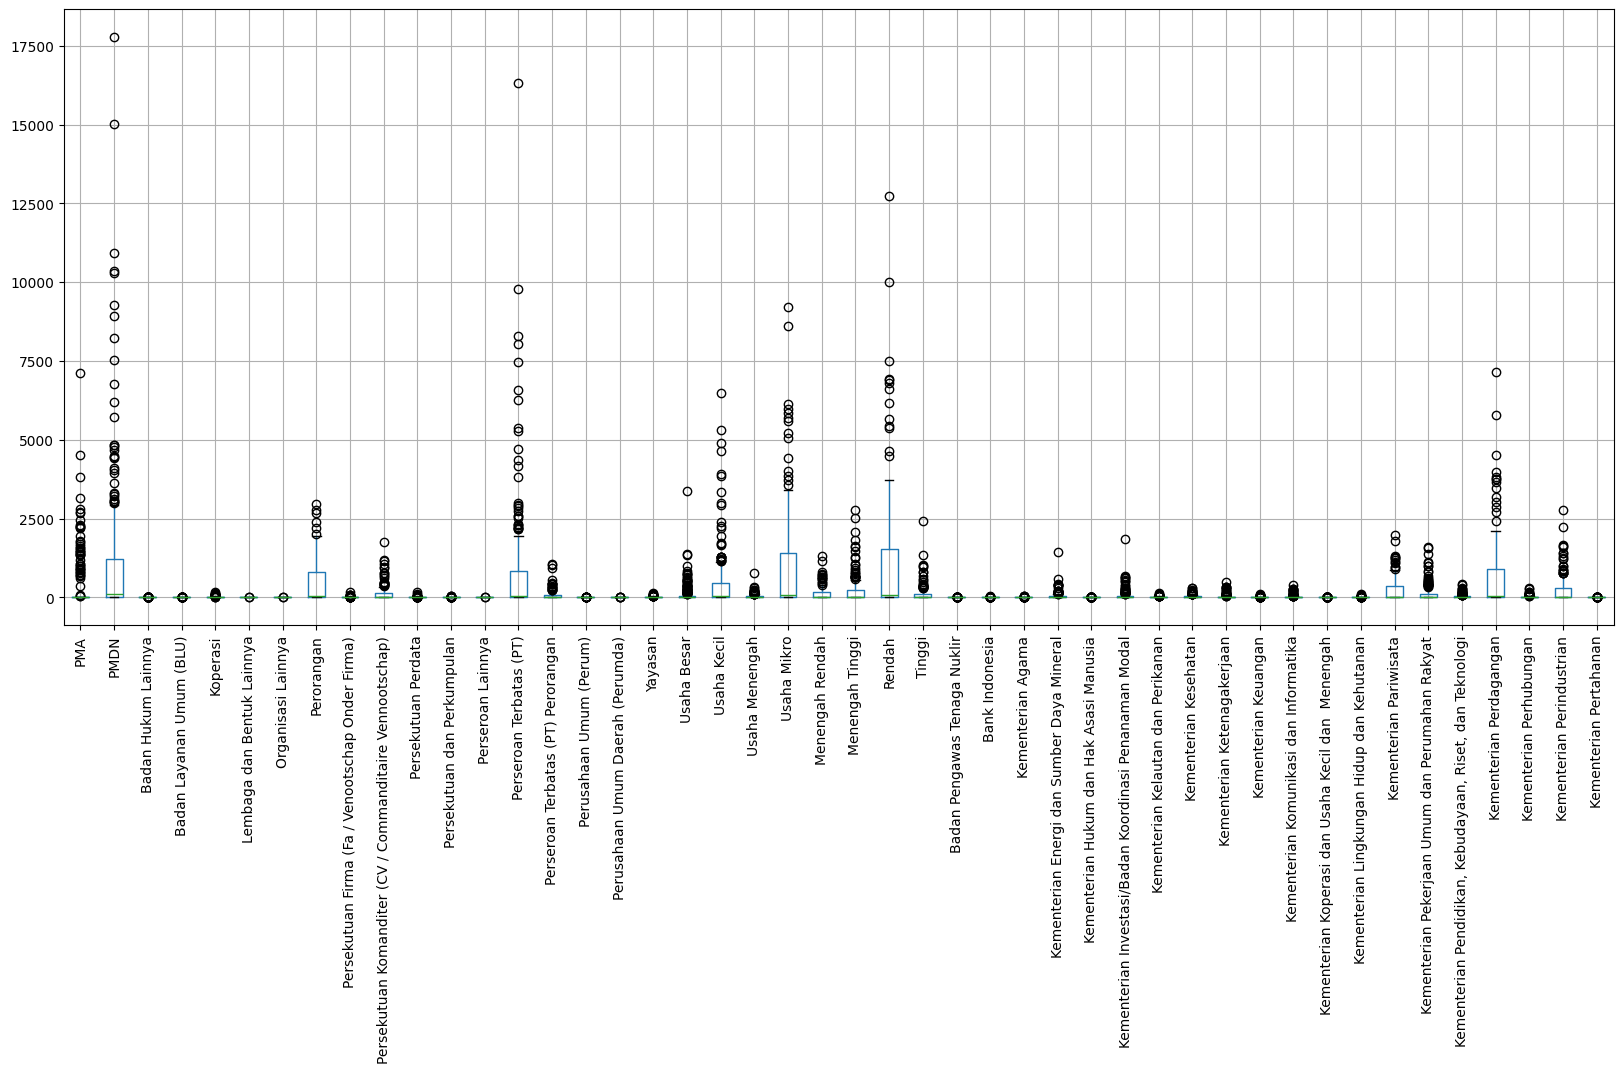

In [45]:
#------------------------------------------------------------------------------------------------------------------------------------------
# EDA for Investasi dan Pengawasan (Exploratory Data Analysis)
#------------------------------------------------------------------------------------------------------------------------------------------

selected_columns = ct_inv_kel.iloc[:,:49]

plt.figure(figsize=(20,8))
selected_columns.boxplot()

plt.xticks(rotation = 90)

In [46]:
scaler = StandardScaler()
ct_inv_kel_scaled = scaler.fit_transform(ct_inv_kel.iloc[:,4:53])
ct_inv_kel_scaled_df = pd.DataFrame(ct_inv_kel_scaled, columns = ct_inv_kel.columns[4:53])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(1, 0, 'PMDN'),
  Text(2, 0, 'Badan Hukum Lainnya'),
  Text(3, 0, 'Badan Layanan Umum (BLU)'),
  Text(4, 0, 'Koperasi'),
  Text(5, 0, 'Lembaga dan Bentuk Lainnya'),
  Text(6, 0, 'Organisasi Lainnya'),
  Text(7, 0, 'Perorangan'),
  Text(8, 0, 'Persekutuan Firma (Fa / Venootschap Onder Firma)'),
  Text(9, 0, 'Persekutuan Komanditer (CV / Commanditaire Vennootschap)'),
  Text(10, 0, 'Persekutuan Perdata'),
  Text(11, 0, 'Persekutuan dan Perkumpulan'),
  Text(12, 0, 'Perseroan Lainnya'),
  Text(13, 0, 'Perseroan Terbatas (PT)'),
  Text(14, 0, 'Perseroan Terbatas (PT) Perorangan'),
  Text(15, 0, 'Perusahaan Umum (Perum)'),
  Text(16, 0, 'Perusahaan Umum Daerah (Perumda)'),
  Text(17, 0, 'Yayasan'),
  Text(18, 0, 'Usaha Besar'),
  Text(19, 0, 'Usaha Kecil'),
  Text(20

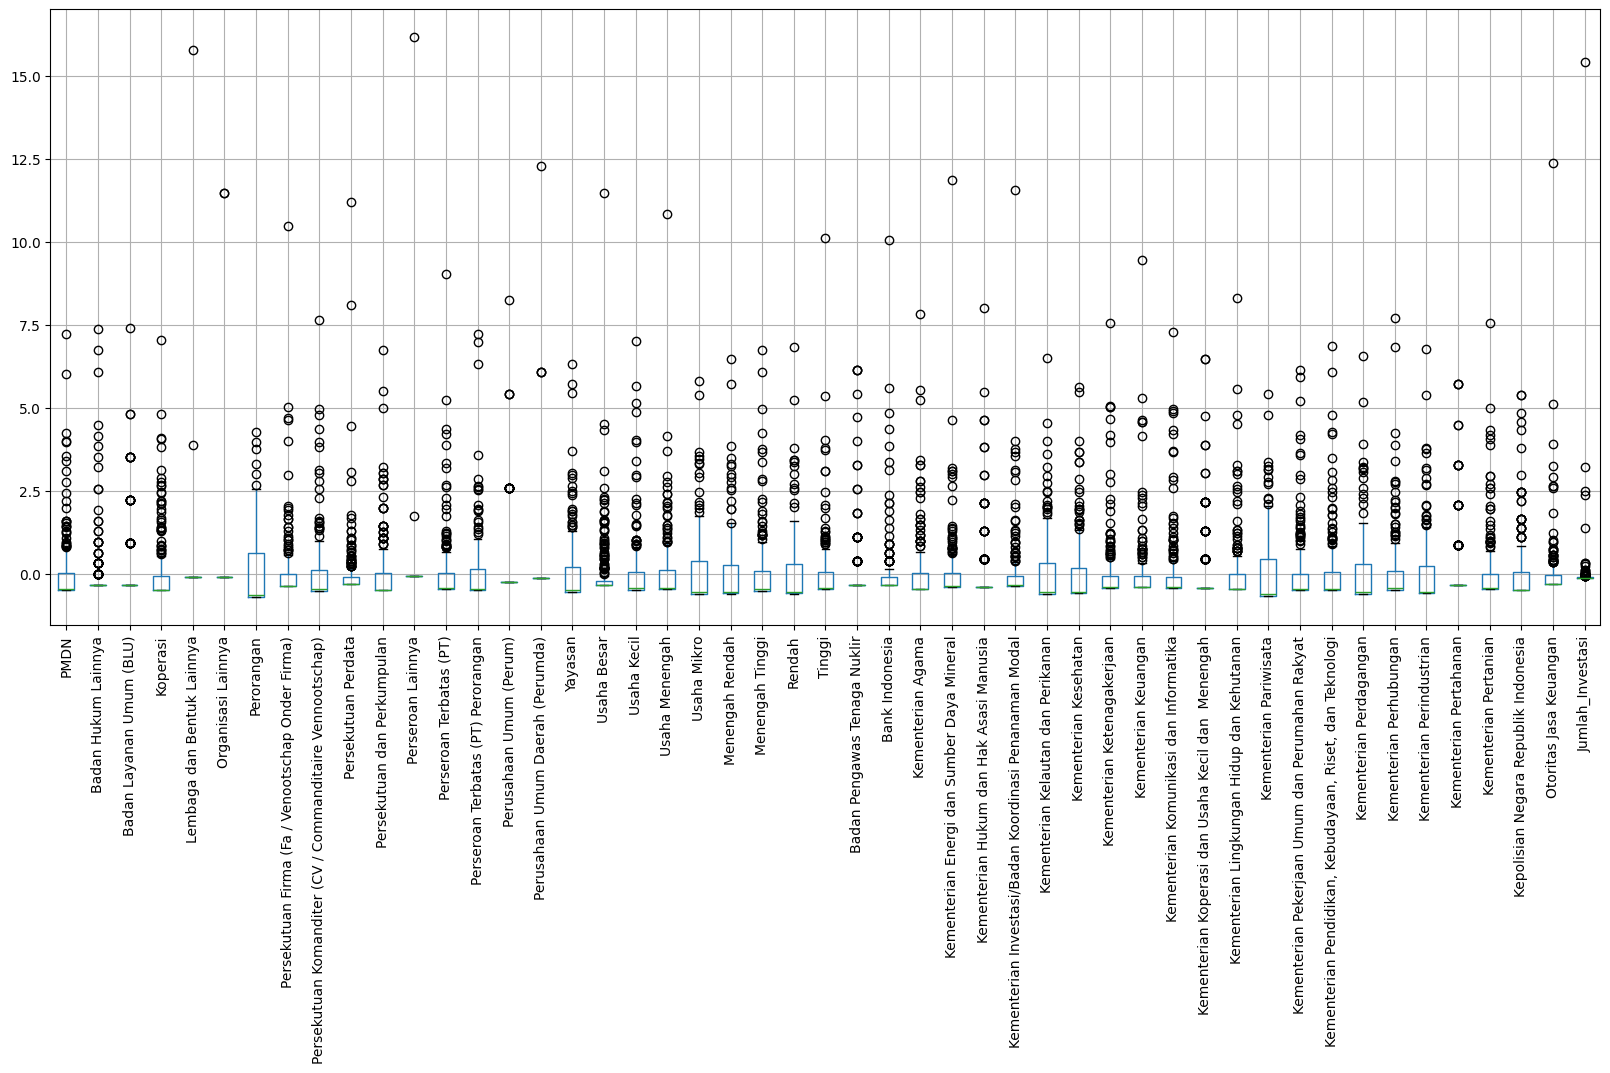

In [47]:
plt.figure(figsize=(20,8))
ct_inv_kel_scaled_df.boxplot()

plt.xticks(rotation = 90)

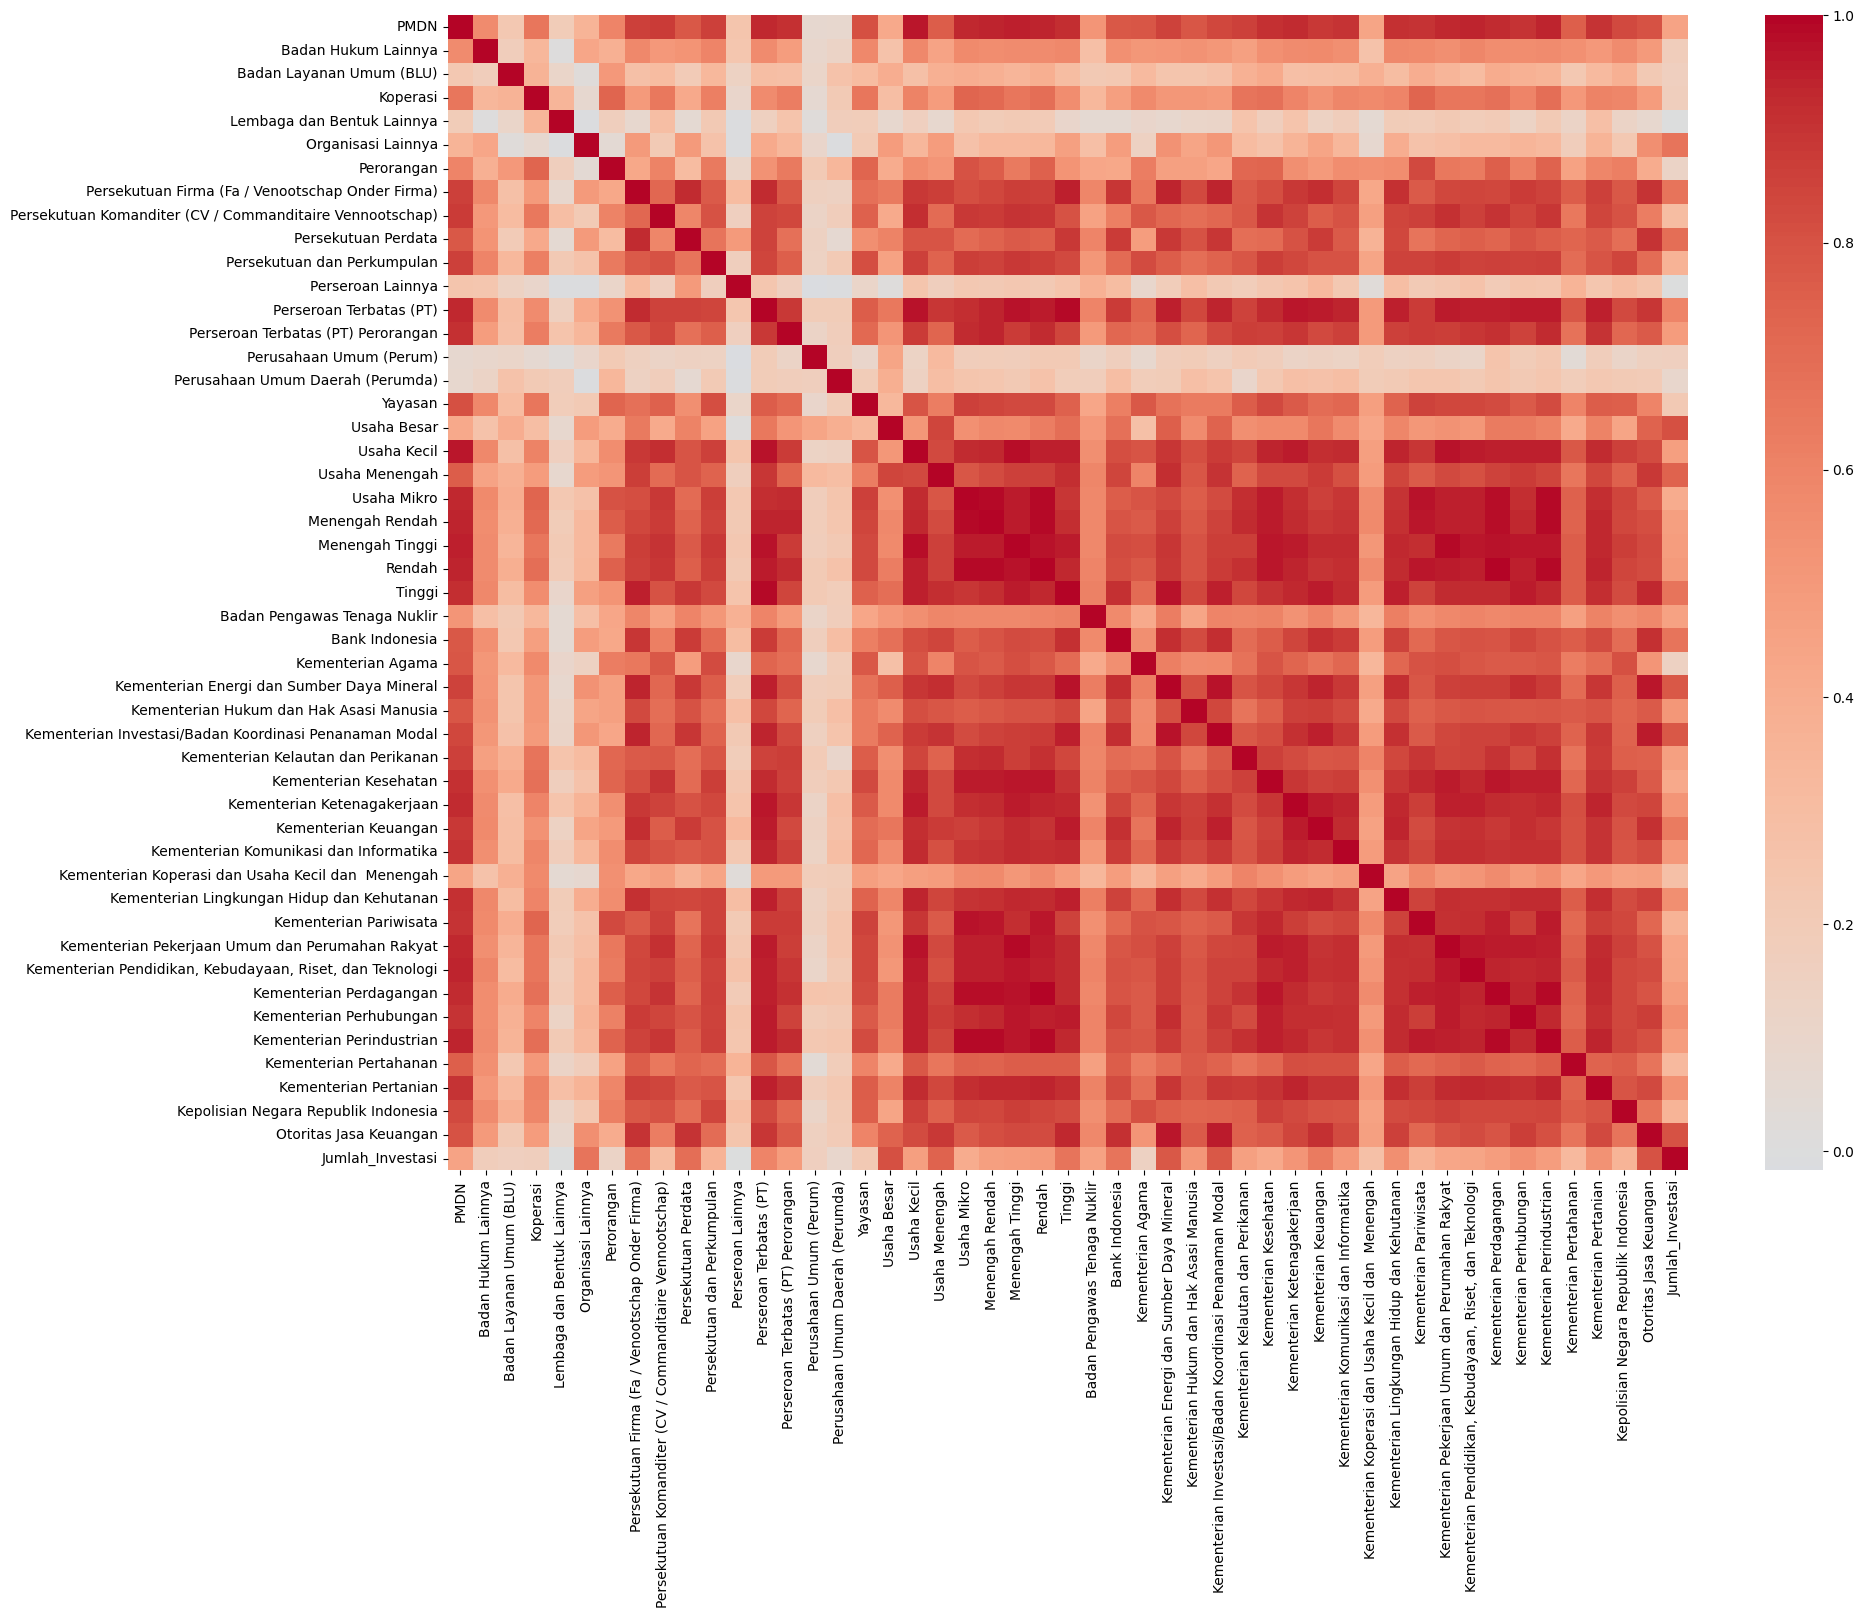

In [48]:
corrmat_inv_kel = ct_inv_kel_scaled_df.corr()
plt.figure(figsize = (20, 15))
sns.heatmap(corrmat_inv_kel, annot = False, cmap='coolwarm', center = 0)
plt.show()

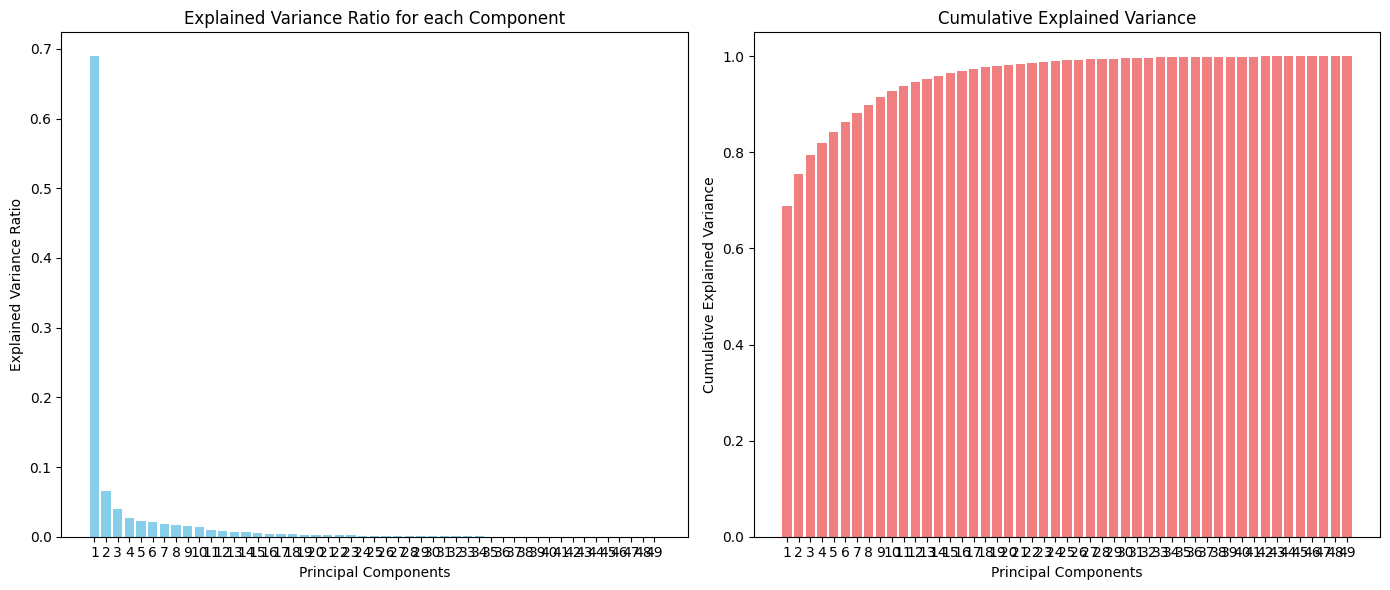

Number of components needed to explain 95% variance: 13


In [49]:
# Apply PCA to the scaled data
pca = PCA()  # Keep all components for analysis
ct_inv_kel_pca = pca.fit_transform(ct_inv_kel_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

# Create a figure and axes for subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for explained variance ratio
ax[0].bar(range(1, len(explained_variance) + 1), explained_variance, color='skyblue')
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].set_title('Explained Variance Ratio for each Component')
ax[0].set_xticks(range(1, len(explained_variance) + 1))

# Plot for cumulative explained variance
ax[1].bar(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, color='lightcoral')
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Cumulative Explained Variance')
ax[1].set_title('Cumulative Explained Variance')
ax[1].set_xticks(range(1, len(cumulative_explained_variance) + 1))

# Display the plots
plt.tight_layout()
plt.show()

# Print the number of components needed to explain 95% of the variance
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Number of components needed to explain 95% variance: {n_components_95}")

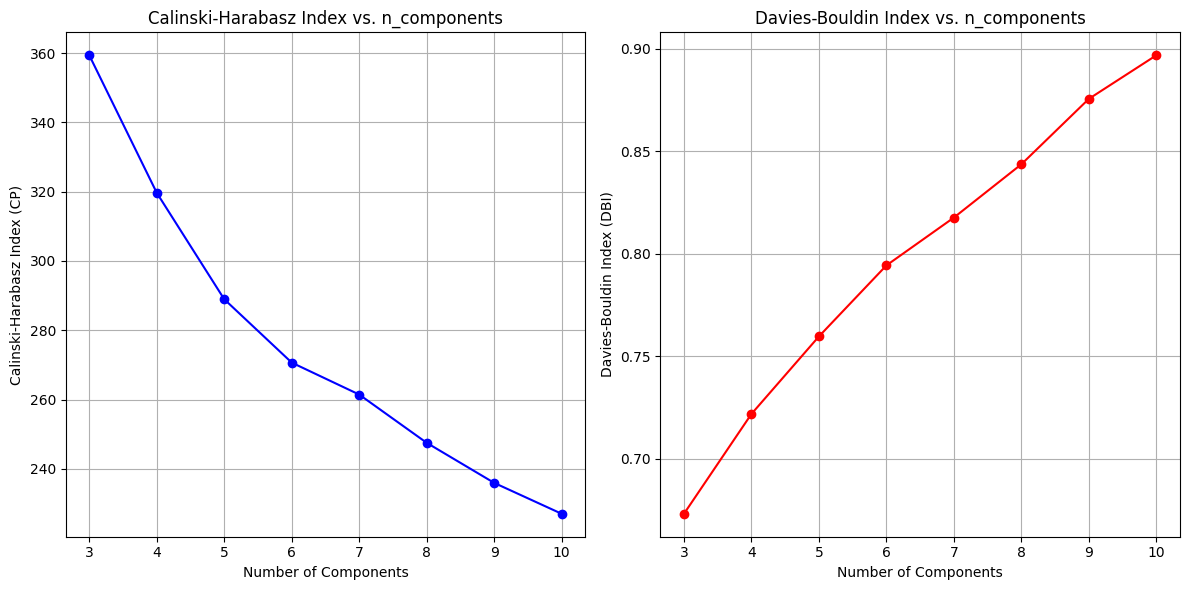

n_components = 3: CP = 359.35, DBI = 0.67
n_components = 4: CP = 319.66, DBI = 0.72
n_components = 5: CP = 288.95, DBI = 0.76
n_components = 6: CP = 270.67, DBI = 0.79
n_components = 7: CP = 261.45, DBI = 0.82
n_components = 8: CP = 247.53, DBI = 0.84
n_components = 9: CP = 235.97, DBI = 0.88
n_components = 10: CP = 227.05, DBI = 0.90


In [50]:
#------------------------------------------------------------------------------------------------------------------------------------------
# KMeans with Euclidian Distance
#------------------------------------------------------------------------------------------------------------------------------------------


# Initialize lists to store the results
components_range = range(3, 11)  # Check from 3 to 10 components
calinski_scores = []
davies_bouldin_scores = []

# Step 1: Loop through each n_components from 3 to 10
for n_components in components_range:
    # Perform PCA with the current number of components
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(ct_inv_kel_scaled)
    
    # Apply K-means clustering (you can adjust the number of clusters if needed)
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(pca_transformed)
    
    # Calculate Calinski-Harabasz Index (CP)
    calinski_harabasz = calinski_harabasz_score(pca_transformed, clusters)
    calinski_scores.append(calinski_harabasz)
    
    # Calculate Davies-Bouldin Index (DBI)
    davies_bouldin = davies_bouldin_score(pca_transformed, clusters)
    davies_bouldin_scores.append(davies_bouldin)

# Step 2: Plot the results
plt.figure(figsize=(12, 6))

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 1)
plt.plot(components_range, calinski_scores, marker='o', color='b')
plt.title('Calinski-Harabasz Index vs. n_components')
plt.xlabel('Number of Components')
plt.ylabel('Calinski-Harabasz Index (CP)')
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(components_range, davies_bouldin_scores, marker='o', color='r')
plt.title('Davies-Bouldin Index vs. n_components')
plt.xlabel('Number of Components')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Output the scores for each n_components
for n_components, cp, dbi in zip(components_range, calinski_scores, davies_bouldin_scores):
    print(f"n_components = {n_components}: CP = {cp:.2f}, DBI = {dbi:.2f}")

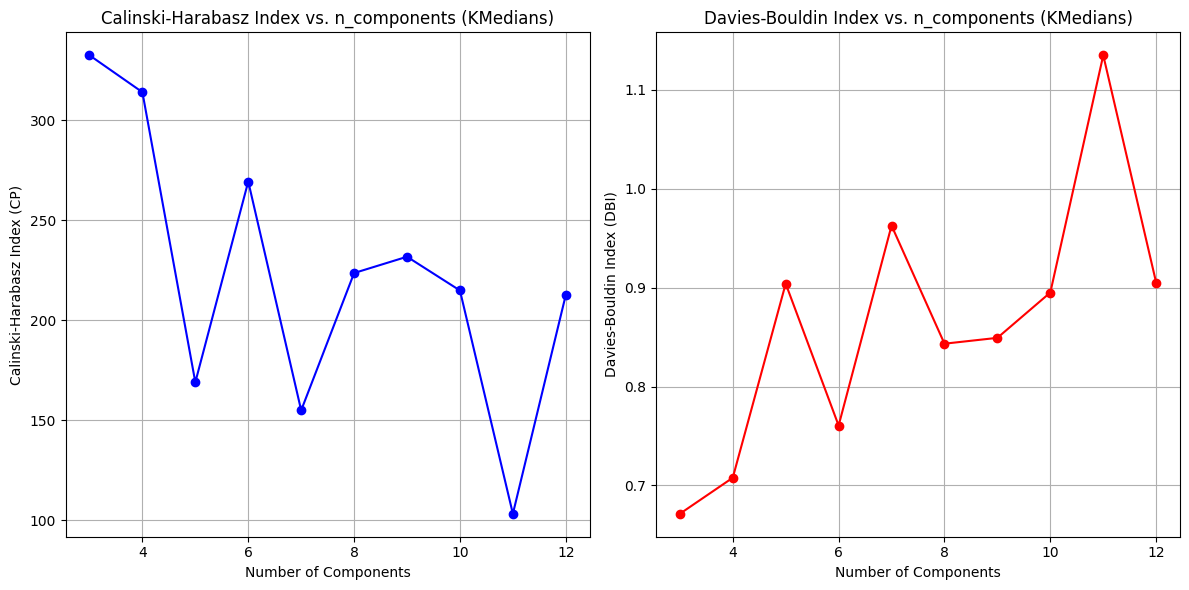

n_components = 3: CP = 332.49, DBI = 0.67
n_components = 4: CP = 314.04, DBI = 0.71
n_components = 5: CP = 169.06, DBI = 0.90
n_components = 6: CP = 269.40, DBI = 0.76
n_components = 7: CP = 155.01, DBI = 0.96
n_components = 8: CP = 223.65, DBI = 0.84
n_components = 9: CP = 231.80, DBI = 0.85
n_components = 10: CP = 214.93, DBI = 0.90
n_components = 11: CP = 103.32, DBI = 1.14
n_components = 12: CP = 212.76, DBI = 0.90


In [51]:
#------------------------------------------------------------------------------------------------------------------------------------------
# KMedians with Manhattan Distance
#------------------------------------------------------------------------------------------------------------------------------------------

# Initialize lists to store the results
components_range = range(3, 13)  # Check from 3 to 13 components
calinski_scores = []
davies_bouldin_scores = []

# Manhattan distance metric
manhattan_metric = distance_metric(type_metric.MANHATTAN)

# Step 1: Loop through each n_components from 3 to 10
for n_components in components_range:
    # Perform PCA with the current number of components
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(ct_inv_kel_scaled)

    # Choose initial medoids (random sample)
    initial_medoids = list(np.random.choice(range(len(pca_transformed)), 3, replace=False))

    # Apply K-medoids clustering
    kmedoids_instance = kmedoids(pca_transformed, initial_medoids, metric=manhattan_metric)
    kmedoids_instance.process()
    clusters = kmedoids_instance.predict(pca_transformed)

    # Calculate Calinski-Harabasz Index (CP)
    calinski_harabasz = calinski_harabasz_score(pca_transformed, clusters)
    calinski_scores.append(calinski_harabasz)

    # Calculate Davies-Bouldin Index (DBI)
    davies_bouldin = davies_bouldin_score(pca_transformed, clusters)
    davies_bouldin_scores.append(davies_bouldin)

# Step 2: Plot the results
plt.figure(figsize=(12, 6))

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 1)
plt.plot(components_range, calinski_scores, marker='o', color='b')
plt.title('Calinski-Harabasz Index vs. n_components (KMedians)')
plt.xlabel('Number of Components')
plt.ylabel('Calinski-Harabasz Index (CP)')
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(components_range, davies_bouldin_scores, marker='o', color='r')
plt.title('Davies-Bouldin Index vs. n_components (KMedians)')
plt.xlabel('Number of Components')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Output the scores for each n_components
for n_components, cp, dbi in zip(components_range, calinski_scores, davies_bouldin_scores):
    print(f"n_components = {n_components}: CP = {cp:.2f}, DBI = {dbi:.2f}")

In [52]:
# Assuming ct_inv_kel is the original DataFrame with sub-district info and other columns
# Ensure that the scaling and PCA transformations were performed on ct_inv_kel_scaled

# Step 1: Perform PCA with n_components = 3 (or the best number based on your evaluation)
pca = PCA(n_components=13)
ct_inv_kel_pca = pca.fit_transform(ct_inv_kel_scaled)

# Step 2: Perform KMeans clustering (3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(ct_inv_kel_pca)

# Step 3: Add the cluster labels to the original DataFrame
# Assuming the sub-district information is in the first column (or another column if applicable)
ct_inv_kel['Cluster'] = cluster_labels

# Step 4: Display the sub-districts (or other relevant identifier) with their corresponding cluster labels
# You can adjust the column name depending on where your sub-district information is stored
sub_district_cluster = ct_inv_kel[['Kelurahan', 'Cluster']] 

# Step 5: Group by cluster to see which sub-districts belong to which cluster
sub_district_cluster_grouped = sub_district_cluster.groupby('Cluster')['Kelurahan'].apply(list)

# Display the result
print(sub_district_cluster_grouped)

Cluster
0    [Cempaka Putih Barat, Cempaka Putih Timur, Cid...
1    [Cengkareng Barat, Cengkareng Timur, Duri Kosa...
2    [Kebon Sirih, Karet Tengsin, Cilandak Barat, S...
Name: Kelurahan, dtype: object


In [53]:
# Step 1: Perform PCA with n_components = 13 (or the best number based on your evaluation)
pca = PCA(n_components=13)  # Adjust n_components based on your evaluation
ct_inv_kel_pca = pca.fit_transform(ct_inv_kel_scaled)

# Step 2: Initialize medoids (choose initial medoid indices, e.g., first three indices)
initial_medoids = [0, 1, 2]  # Ensure the indices are valid for the data size

# Step 3: Use Manhattan distance metric
manhattan_metric = distance_metric(type_metric.MANHATTAN)

# Step 4: Perform K-Median clustering with the specified metric
kmedoids_instance = kmedoids(data=ct_inv_kel_pca.tolist(), initial_index_medoids=initial_medoids, metric=manhattan_metric)
kmedoids_instance.process()  # Run the algorithm

# Step 5: Retrieve cluster labels
clusters = kmedoids_instance.get_clusters()  # List of cluster indices for each cluster
cluster_labels = np.zeros(len(ct_inv_kel_pca), dtype=int)  # Initialize cluster labels
for cluster_id, cluster_indices in enumerate(clusters):
    for index in cluster_indices:
        cluster_labels[index] = cluster_id  # Assign cluster ID to the corresponding data point

# Step 6: Add the cluster labels to the original DataFrame
ct_inv_kel['Cluster2'] = cluster_labels

# Step 7: Display the sub-districts (or other relevant identifier) with their corresponding cluster labels
sub_district_cluster2 = ct_inv_kel[['Kelurahan', 'Cluster2']]

# Step 8: Group by cluster to see which sub-districts belong to which cluster
sub_district_cluster_grouped2 = sub_district_cluster2.groupby('Cluster2')['Kelurahan'].apply(list)

# Display the result
print(sub_district_cluster_grouped2)

Cluster2
0    [Cempaka Putih Barat, Cempaka Putih Timur, Cid...
1    [Cengkareng Barat, Cengkareng Timur, Duri Kosa...
2    [Kebon Sirih, Karet Tengsin, Cilandak Barat, S...
Name: Kelurahan, dtype: object


In [54]:
sub_district_cluster.groupby('Cluster').size()

Cluster
0     65
1    188
2     12
dtype: int64

In [55]:
sub_district_cluster2.groupby('Cluster2').size()

Cluster2
0     74
1    179
2     12
dtype: int64

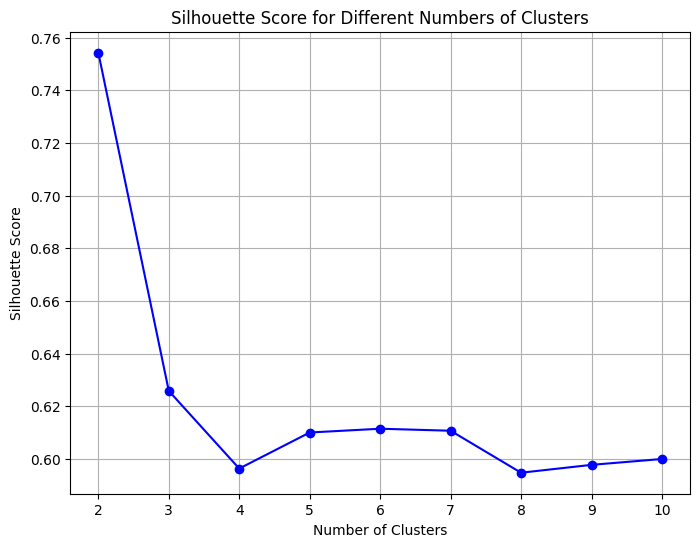

          0
0  0.754293
1  0.625817
2  0.596313
3  0.610009
4  0.611447
5  0.610683
6  0.594731
7  0.597723
8  0.599949


In [56]:
# Assuming ct_inv_kel_scaled is already scaled and ct_inv_kel_pca is the PCA transformed data

# List to store silhouette scores
silhouette_scores = []

# Range of clusters from 2 to 10 (silhouette score is undefined for 1 cluster)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(ct_inv_kel_pca)  # Use the PCA-transformed data
    score = silhouette_score(ct_inv_kel_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting silhouette scores across the number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))  # Show cluster sizes from 2 to 10
plt.grid(True)
plt.show()

print(pd.DataFrame(silhouette_scores))

In [57]:
cluster_invpeng = ct_inv_kel[['Kota','Kecamatan','Kelurahan', 'Cluster','Cluster2']] 
cluster_invpeng.to_excel('cluster_invpeng.xlsx', index=False)

In [58]:
# Assuming `ct_inv_kel` is the DataFrame with clustering results
# Replace 'Cluster2' with the name of the clustering column if different

# Group the data by clusters
clustered_data = ct_inv_kel.iloc[:, 3:].groupby('Cluster')

# Function to calculate descriptive statistics for each cluster
def calculate_stats(group):
    stats = {
        "Mean": group.mean(),
        "Standard Deviation": group.std(),
        "Min": group.min(),
        "Q1 (25%)": group.quantile(0.25),
        "Q2 (50%)": group.median(),
        "Q3 (75%)": group.quantile(0.75),
        "Max": group.max(),
    }
    return pd.DataFrame(stats)

# Apply the statistics function to each cluster
descriptive_stats = clustered_data.apply(calculate_stats)
descriptive_stats = descriptive_stats.stack(level=0).unstack(level=0)

# Display the result
# Use `.loc` if you want statistics for a specific column (e.g., 'some_column_name')
print(descriptive_stats)
descriptive_stats.to_excel('inv_descriptive_stats.xlsx')

Cluster                                0           1            2
PMA      Mean                 777.507692   83.728723  1043.083333
         Standard Deviation  1101.117573  265.775720  2221.213856
         Min                    0.000000    0.000000     1.000000
         Q1 (25%)               1.000000    0.000000     7.000000
         Q2 (50%)               5.000000    0.000000    12.500000
...                                  ...         ...          ...
Cluster2 Min                    0.000000    0.000000     2.000000
         Q1 (25%)               0.000000    1.000000     2.000000
         Q2 (50%)               0.000000    1.000000     2.000000
         Q3 (75%)               0.000000    1.000000     2.000000
         Max                    0.000000    1.000000     2.000000

[364 rows x 3 columns]


/var/folders/qj/vt4rcyh91s35vhsqftj_6fhh0000gn/T/ipykernel_4382/1373856387.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  descriptive_stats = clustered_data.apply(calculate_stats)


# **Clustering Investasi 2#**

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(1, 0, 'Menengah Rendah'),
  Text(2, 0, 'Menengah Tinggi'),
  Text(3, 0, 'Rendah'),
  Text(4, 0, 'Tinggi'),
  Text(5, 0, 'Badan Pengawas Tenaga Nuklir'),
  Text(6, 0, 'Bank Indonesia'),
  Text(7, 0, 'Kementerian Agama'),
  Text(8, 0, 'Kementerian Energi dan Sumber Daya Mineral'),
  Text(9, 0, 'Kementerian Hukum dan Hak Asasi Manusia'),
  Text(10, 0, 'Kementerian Investasi/Badan Koordinasi Penanaman Modal'),
  Text(11, 0, 'Kementerian Kelautan dan Perikanan'),
  Text(12, 0, 'Kementerian Kesehatan'),
  Text(13, 0, 'Kementerian Ketenagakerjaan'),
  Text(14, 0, 'Kementerian Keuangan'),
  Text(15, 0, 'Kementerian Komunikasi dan Informatika'),
  Text(16, 0, 'Kementerian Koperasi dan Usaha Kecil dan  Menengah'),
  Text(17, 0, 'Kementerian Lingkungan Hidup dan Kehutanan'),
  Text(18, 0, 'Kementerian Pariwisata'),
  Text(19, 0, 'Kementerian Pekerjaan Umum dan Perum

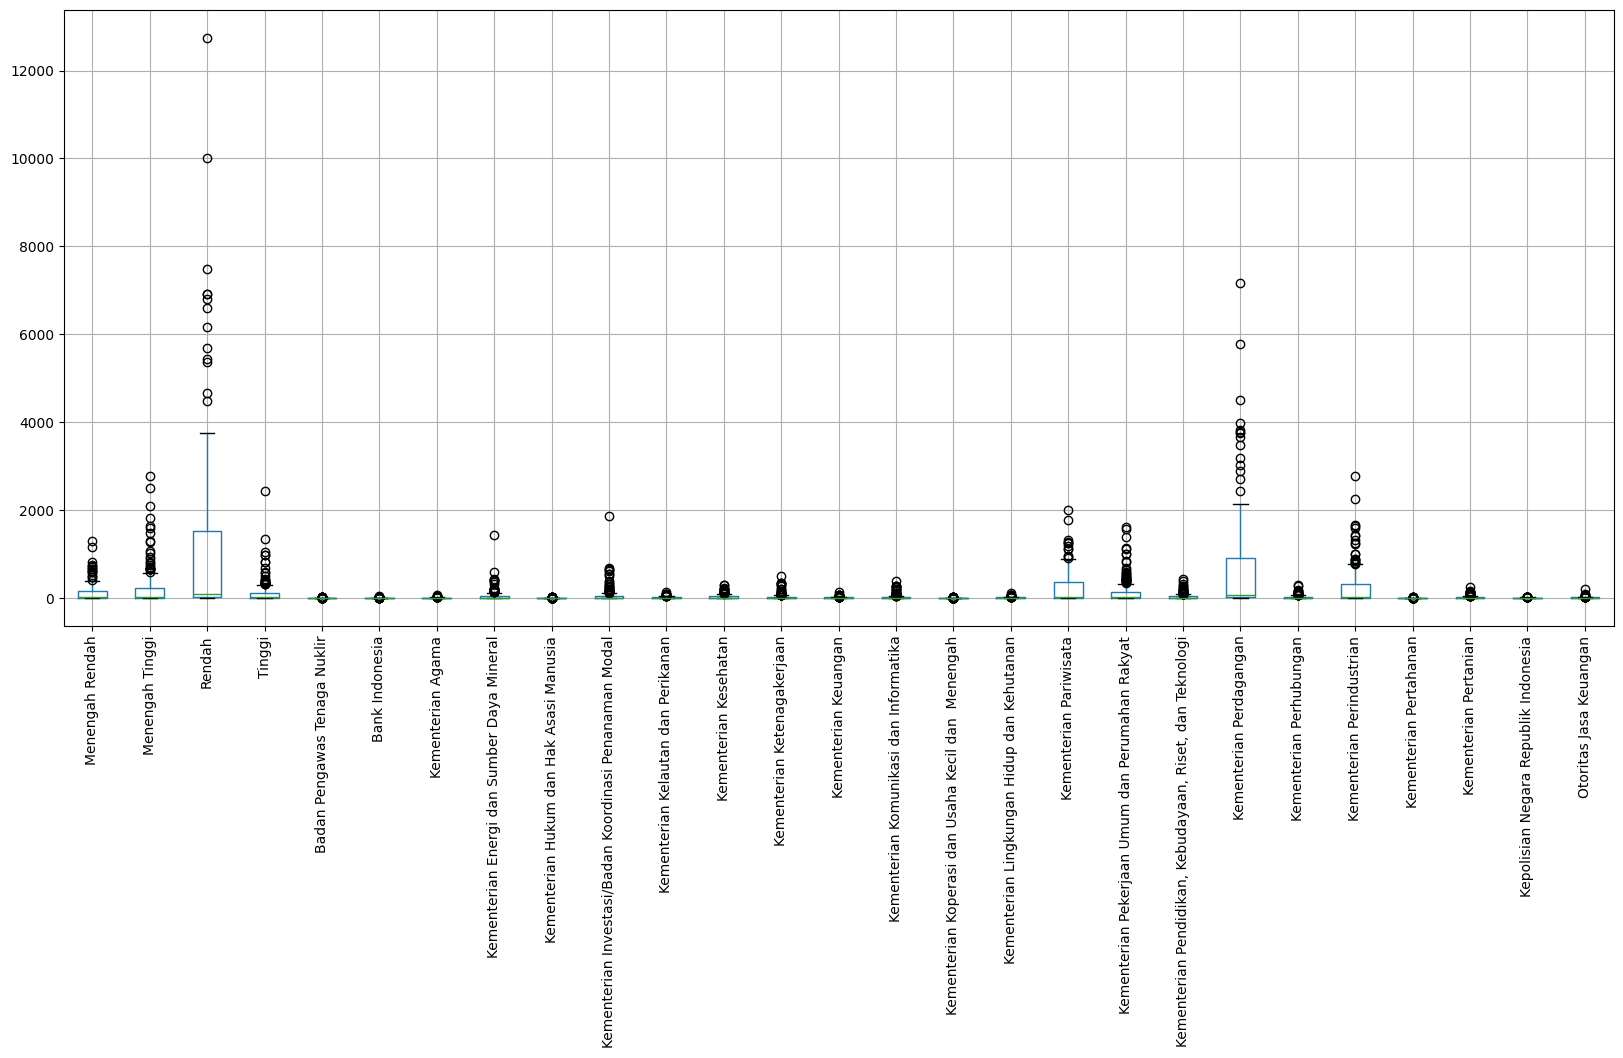

In [65]:
#------------------------------------------------------------------------------------------------------------------------------------------
# EDA for Investasi dan Pengawasan (Exploratory Data Analysis)
#------------------------------------------------------------------------------------------------------------------------------------------

selected_columns = ct_inv_kel.iloc[:,25:52]

plt.figure(figsize=(20,8))
selected_columns.boxplot()

plt.xticks(rotation = 90)

In [75]:
scaler = StandardScaler()
ct_inv_kel_scaled = scaler.fit_transform(ct_inv_kel.iloc[:,29:52])
ct_inv_kel_scaled_df = pd.DataFrame(ct_inv_kel_scaled, columns = ct_inv_kel.columns[29:52])

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23]),
 [Text(1, 0, 'Badan Pengawas Tenaga Nuklir'),
  Text(2, 0, 'Bank Indonesia'),
  Text(3, 0, 'Kementerian Agama'),
  Text(4, 0, 'Kementerian Energi dan Sumber Daya Mineral'),
  Text(5, 0, 'Kementerian Hukum dan Hak Asasi Manusia'),
  Text(6, 0, 'Kementerian Investasi/Badan Koordinasi Penanaman Modal'),
  Text(7, 0, 'Kementerian Kelautan dan Perikanan'),
  Text(8, 0, 'Kementerian Kesehatan'),
  Text(9, 0, 'Kementerian Ketenagakerjaan'),
  Text(10, 0, 'Kementerian Keuangan'),
  Text(11, 0, 'Kementerian Komunikasi dan Informatika'),
  Text(12, 0, 'Kementerian Koperasi dan Usaha Kecil dan  Menengah'),
  Text(13, 0, 'Kementerian Lingkungan Hidup dan Kehutanan'),
  Text(14, 0, 'Kementerian Pariwisata'),
  Text(15, 0, 'Kementerian Pekerjaan Umum dan Perumahan Rakyat'),
  Text(16, 0, 'Kementerian Pendidikan, Kebudayaan, Riset, dan Teknologi'),
  Text(17, 0, 'Kementerian Perdagangan'),
  

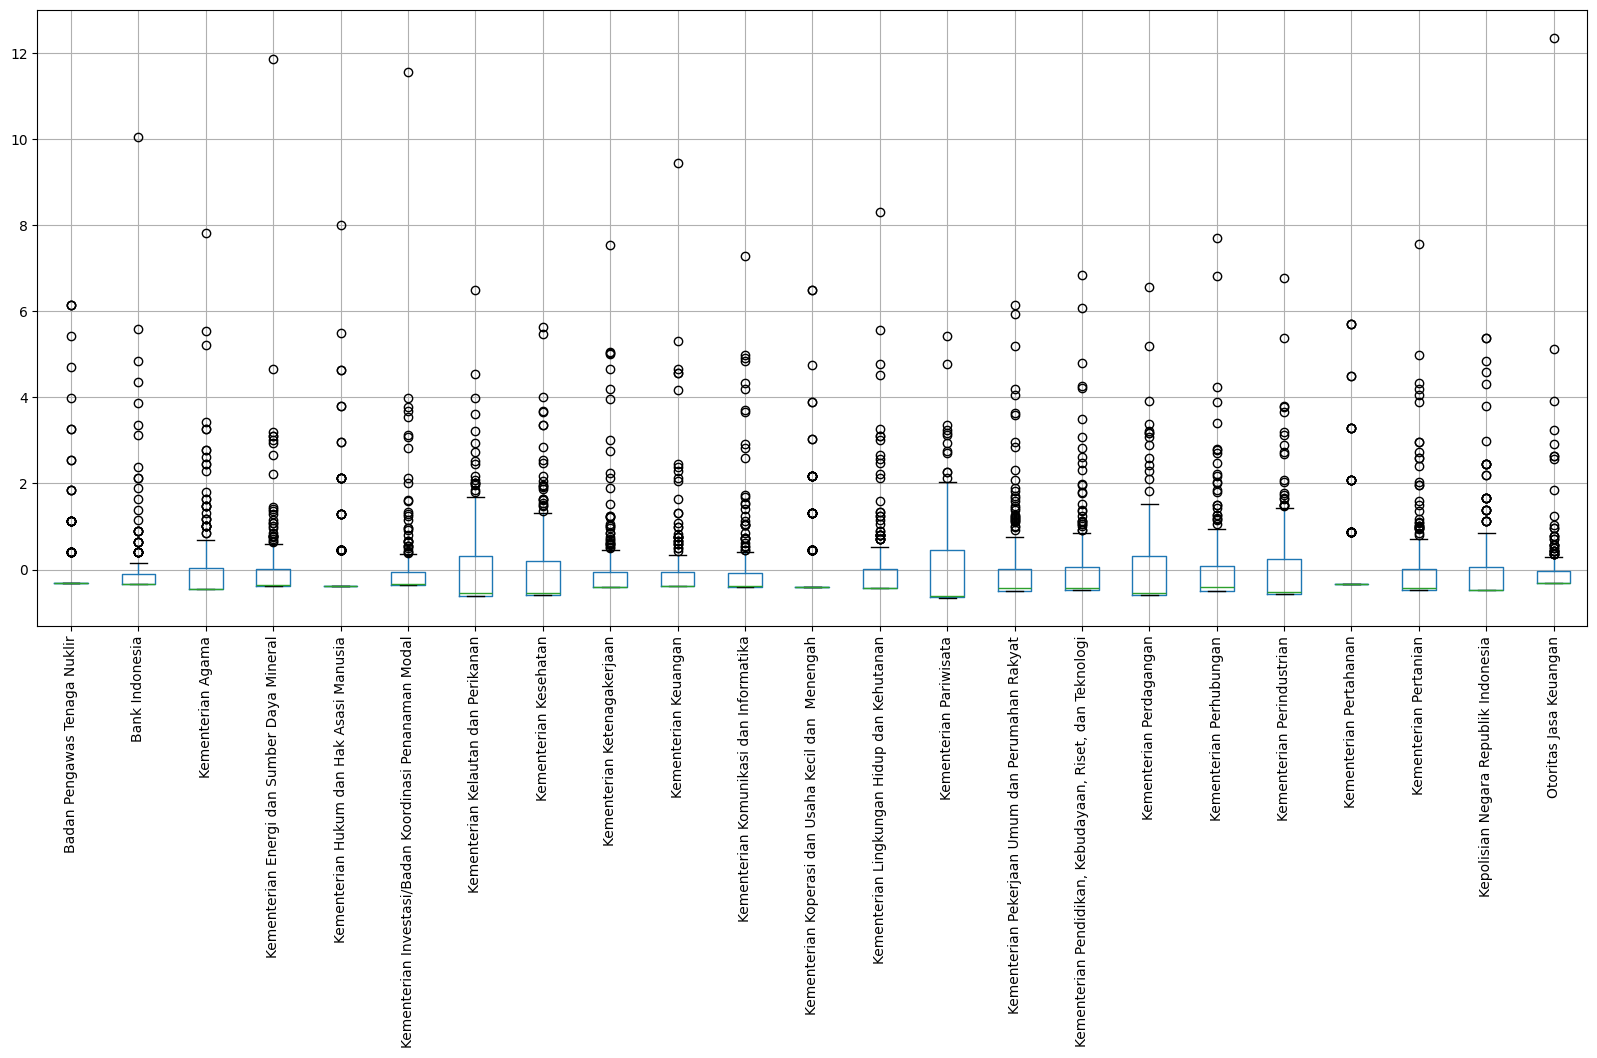

In [76]:
plt.figure(figsize=(20,8))
ct_inv_kel_scaled_df.boxplot()

plt.xticks(rotation = 90)

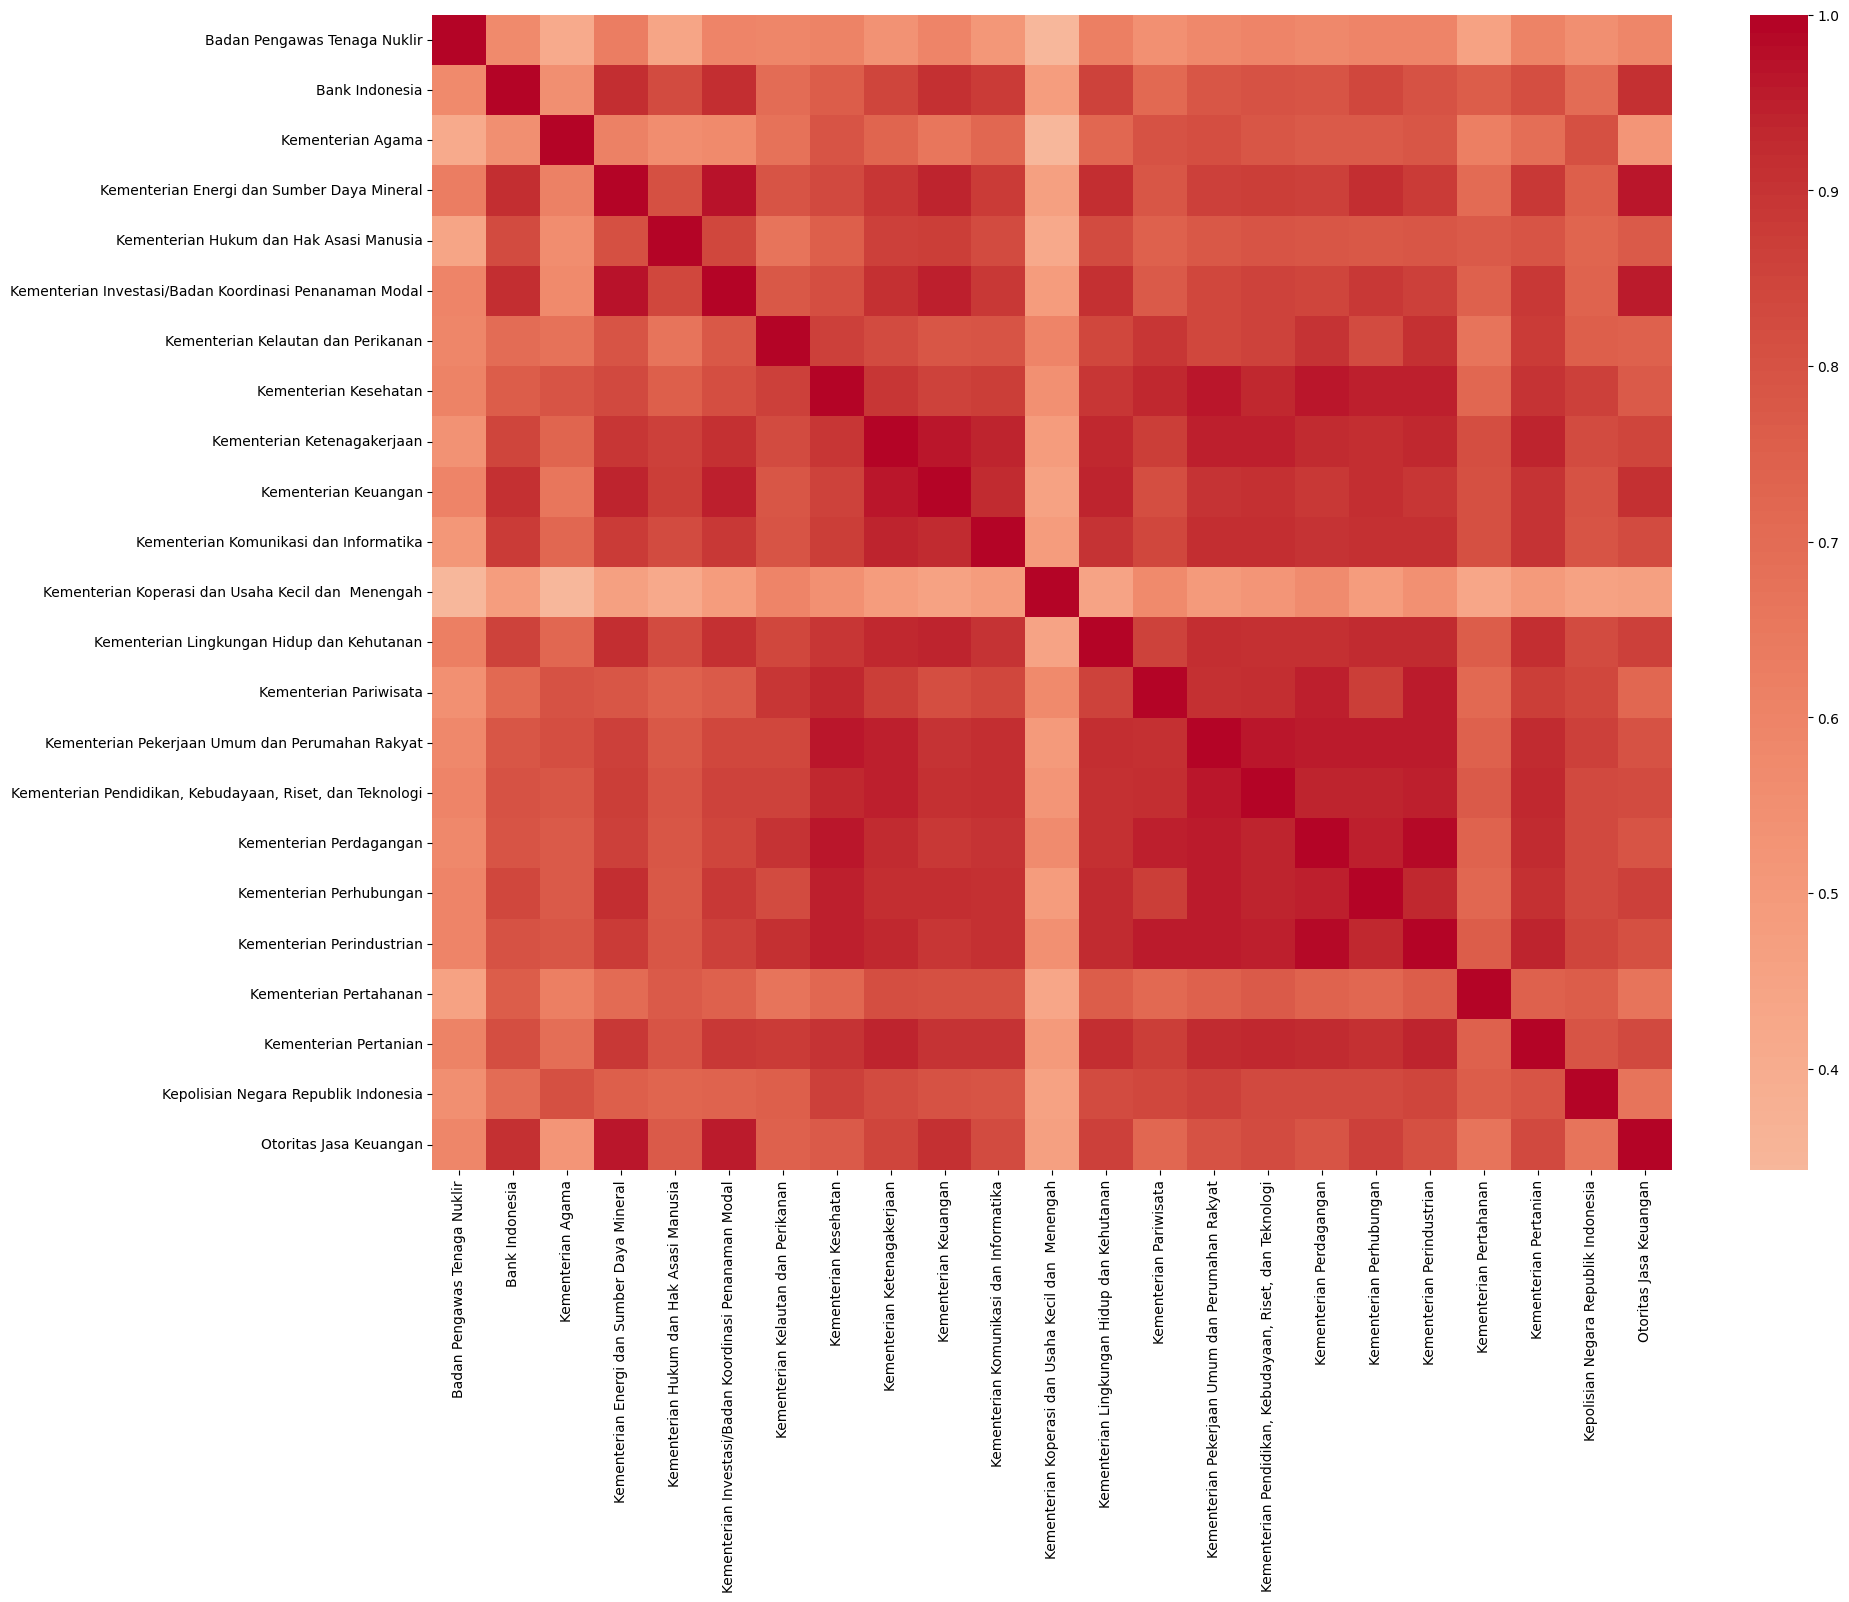

In [77]:
corrmat_inv_kel = ct_inv_kel_scaled_df.corr()
plt.figure(figsize = (20, 15))
sns.heatmap(corrmat_inv_kel, annot = False, cmap='coolwarm', center = 0)
plt.show()

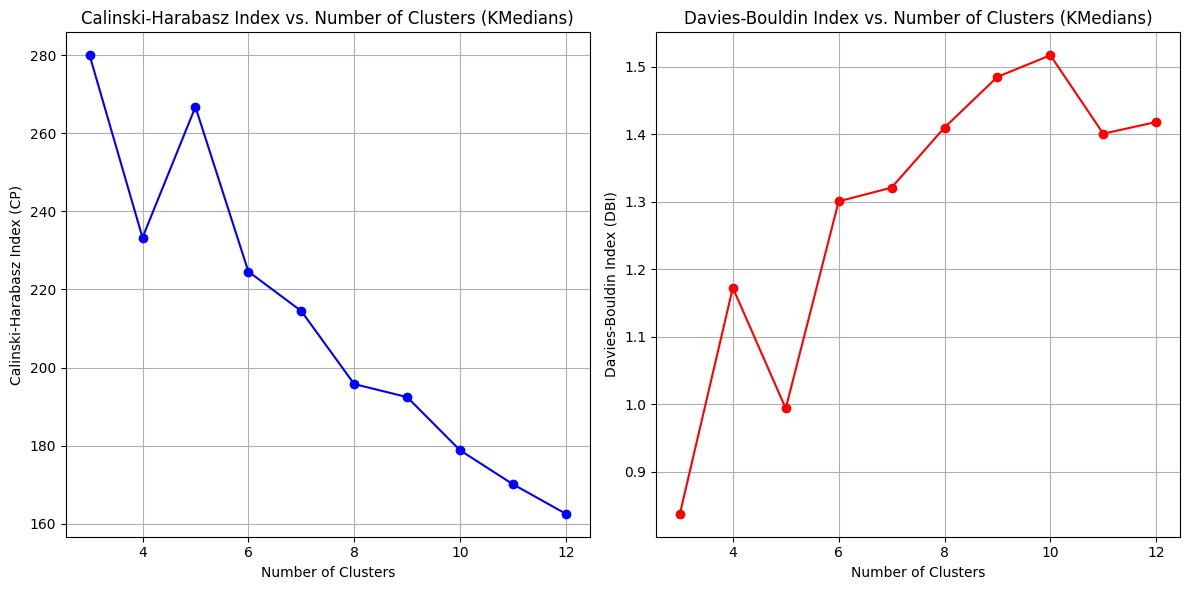

n_clusters = 3: CP = 280.02, DBI = 0.84
n_clusters = 4: CP = 233.30, DBI = 1.17
n_clusters = 5: CP = 266.80, DBI = 0.99
n_clusters = 6: CP = 224.60, DBI = 1.30
n_clusters = 7: CP = 214.48, DBI = 1.32
n_clusters = 8: CP = 195.77, DBI = 1.41
n_clusters = 9: CP = 192.43, DBI = 1.49
n_clusters = 10: CP = 178.80, DBI = 1.52
n_clusters = 11: CP = 170.09, DBI = 1.40
n_clusters = 12: CP = 162.52, DBI = 1.42


In [86]:
#------------------------------------------------------------------------------------------------------------------------------------------
# KMedians with Manhattan Distance
#------------------------------------------------------------------------------------------------------------------------------------------

# Initialize lists to store the results
components_range = range(3, 13)  # Check from 3 to 13 clusters
calinski_scores = []
davies_bouldin_scores = []

# Manhattan distance metric
manhattan_metric = distance_metric(type_metric.MANHATTAN)

# Step 1: Loop through each number of clusters
for n_clusters in components_range:
    # Choose initial medoids (random sample)
    initial_medoids = list(np.random.choice(range(len(ct_inv_kel_scaled)), n_clusters, replace=False))

    # Apply K-medoids clustering
    kmedoids_instance = kmedoids(ct_inv_kel_scaled, initial_medoids, metric=manhattan_metric)
    kmedoids_instance.process()
    clusters = kmedoids_instance.predict(ct_inv_kel_scaled)

    # Calculate Calinski-Harabasz Index (CP)
    calinski_harabasz = calinski_harabasz_score(ct_inv_kel_scaled, clusters)
    calinski_scores.append(calinski_harabasz)

    # Calculate Davies-Bouldin Index (DBI)
    davies_bouldin = davies_bouldin_score(ct_inv_kel_scaled, clusters)
    davies_bouldin_scores.append(davies_bouldin)

# Step 2: Plot the results
plt.figure(figsize=(12, 6))

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 1)
plt.plot(components_range, calinski_scores, marker='o', color='b')
plt.title('Calinski-Harabasz Index vs. Number of Clusters (KMedians)')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index (CP)')
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(components_range, davies_bouldin_scores, marker='o', color='r')
plt.title('Davies-Bouldin Index vs. Number of Clusters (KMedians)')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index (DBI)')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Output the scores for each n_clusters
for n_clusters, cp, dbi in zip(components_range, calinski_scores, davies_bouldin_scores):
    print(f"n_clusters = {n_clusters}: CP = {cp:.2f}, DBI = {dbi:.2f}")

In [92]:
# Step 1: Use the original scaled dataset
data = ct_inv_kel_scaled  # Ensure this is your preprocessed (scaled) data

# Step 2: Initialize medoids (choose initial medoid indices, e.g., first three indices)
initial_medoids = [0, 1, 2, 3, 4]  # Ensure these indices are valid for the data size

# Step 3: Use Manhattan distance metric
manhattan_metric = distance_metric(type_metric.MANHATTAN)

# Step 4: Perform K-Median clustering with the specified metric
kmedoids_instance = kmedoids(data=data.tolist(), initial_index_medoids=initial_medoids, metric=manhattan_metric)
kmedoids_instance.process()  # Run the algorithm

# Step 5: Retrieve cluster labels
clusters = kmedoids_instance.get_clusters()  # List of cluster indices for each cluster
cluster_labels = np.zeros(len(data), dtype=int)  # Initialize cluster labels
for cluster_id, cluster_indices in enumerate(clusters):
    for index in cluster_indices:
        cluster_labels[index] = cluster_id  # Assign cluster ID to the corresponding data point

# Step 6: Add the cluster labels to the original DataFrame
ct_inv_kel['Cluster2'] = cluster_labels

# Step 7: Display the sub-districts (or other relevant identifier) with their corresponding cluster labels
sub_district_cluster2 = ct_inv_kel[['Kelurahan', 'Cluster2']]

# Step 8: Group by cluster to see which sub-districts belong to which cluster
sub_district_cluster_grouped2 = sub_district_cluster2.groupby('Cluster2')['Kelurahan'].apply(list)

# Display the result
print(sub_district_cluster_grouped2)

Cluster2
0    [Kebon Sirih, Karet Tengsin, Cilandak Barat, P...
1    [Cempaka Putih Timur, Gambir, Petojo Selatan, ...
2    [Kebon Jeruk, Cempaka Putih Barat, Cideng, Keb...
3                                            [Senayan]
4    [Cengkareng Barat, Cengkareng Timur, Duri Kosa...
Name: Kelurahan, dtype: object


In [93]:
sub_district_cluster2.groupby('Cluster2').size()

Cluster2
0      9
1     25
2     56
3      1
4    174
dtype: int64

# **Tambahan**